In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager , rc
import requests
import json
import numpy as np
!pip install optuna
import optuna
!pip install tqdm
from tqdm import tqdm
from pandas import concat
from sklearn.model_selection import train_test_split
!pip install statsmodels
# font_path = '/usr/share/fonts/truetype/nanum/NanumSquareRoundL.ttf'
# font = font_manager.FontProperties(fname=font_path).get_name()
# c('font', family = font)
pd.options.display.float_format = '{:.2f}'.format

!pip install sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from pandas import concat


import warnings
warnings.filterwarnings('ignore')

In [3]:
#2022년 8월 4일 기준 지역화폐 가맹점 현황 데이터
지역화폐가맹점 = pd.read_csv('경기도_화성시_지역화폐가맹점(2200804).csv',encoding = 'utf_8')

## 지역화폐 시각화

### 지역화폐사용률 시각화

In [7]:
#2017년~2022년 화성시 결제 데이터
결제데이터 = pd.read_csv('BC카드 결제데이터, 지역화폐_월별 ascsv.csv')

#빈 row 및 nan값 전처리
결제데이터 = 결제데이터.drop([72,73,74,75,76,77], axis=0)
결제데이터 =결제데이터.fillna(0)

In [8]:
#각 column별 str 타입 데이터 int 타입으로 변환


결제데이터

def str_to_int(string):
    if type(string) == str:
        string = string.replace(',', '')
        return int(string)
    else:
        return string
    
결제데이터.iloc[:,2] = 결제데이터.iloc[:,2].apply(str_to_int)
결제데이터.iloc[:,3] = 결제데이터.iloc[:,3].apply(str_to_int)
결제데이터.iloc[:,4] = 결제데이터.iloc[:,4].apply(str_to_int)

결제데이터=결제데이터.astype(int)

#지역화폐결제금액/총 결제금액 = 지역화폐 사용률 column생성
결제데이터['지역화폐사용률']=((결제데이터.iloc[:,4]/결제데이터.iloc[:,3])*100).astype(float)

In [9]:
#seabon 및 matplotlib 패키지 import / 시각화에 한글폰트 사용

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", 
rc={"axes.unicode_minus":False}, style='white')

In [10]:
#2017~2022년까지 첫 1월에 해당하는 데이터 빼고 ' '으로 대치해 시각화 데이터 xlable로 사용 -> 각 연도를 의미

xlabels=[]
for ii,v in enumerate(결제데이터['연도']):
    if ii  % 12 ==0:
        xlabels.append(v)
    else:
        xlabels.append(" ")


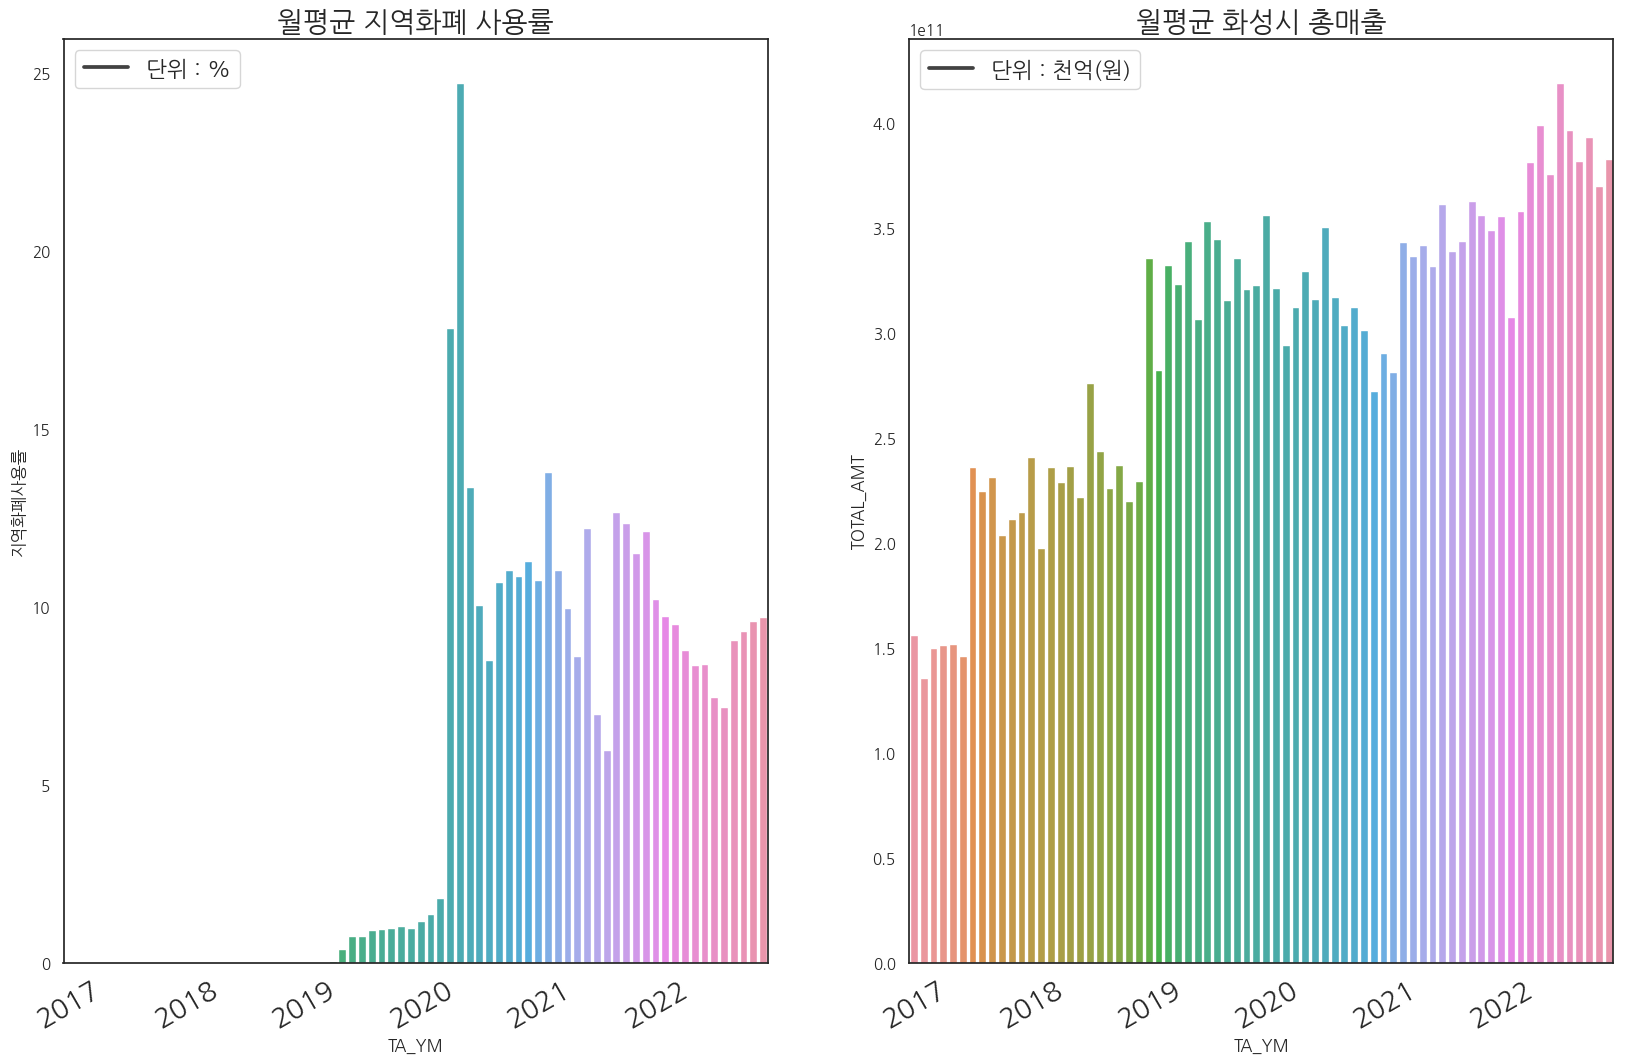

In [11]:
# 화성시 지역화폐 사용률 및 총매출 데이터 시각화


fig, axs = plt.subplots(ncols= 2, figsize=(20,12))
axs[0].set_title("월평균 지역화폐 사용률" , fontsize=20)
axs[1].set_title("월평균 화성시 총매출", fontsize=20)




A=sns.barplot(x="TA_YM", y='지역화폐사용률', data=결제데이터,ax=axs[0])
B=sns.barplot(x="TA_YM", y=" TOTAL_AMT ", data=결제데이터,ax=axs[1])


A.legend(labels = ['단위 : %'],loc = 'upper left',fontsize=16)
B.legend(labels = ['단위 : 천억(원)'],loc = 'upper left',fontsize=16)

_=axs[0].set_xticklabels(xlabels, size=20,rotation = 30)
_=axs[1].set_xticklabels(xlabels, size=20,rotation = 30)


# 지역화폐가맹점 데이터 전처리

### 대분류명 칼럼 넣기

In [12]:
# 각 업종을 대분류명으로 분류하여 대분류명 column 생성

a = []

for i in 지역화폐가맹점['업종명']:
    if '숙박' in i:
        a.append('숙박업')
        
    if ('관광' in i) or ('콘도' in i) or ('여객' in i):
        a.append('여행업')
    
    if ('스포츠 레져용품' in i) or ('골프용품' in i):
        a.append('레져용품')
    
    if ('레져업소' in i) or ('당 구 장' in i) or ('스크린' in i) or ('볼 링 장' in i) or ('연습장' in i) or ('테니스' in i) or ('수 영' in i) or ('레져타운' in i):
        a.append('레져업소')
        
    if ('사우' in i) or ('문화취미' in i) or ('노 래' in i) or ('수족' in i) or ('음반' in i):
        a.append('문화/취미')
        
    if ('가구' in i) or ('카페트' in i) or ('침구 수예' in i) or ('시계' in i) or ('철제' in i):
        a.append('가구')
        
        
    if ('컴퓨' in i) or ('전기제품' in i) or ('가전' in i) or ('냉열' in i) or ('정수' in i) or ('조명' in i):    
        if i != '컴퓨터학원':
            a.append('가전제품')
         
        
    if '주방용' in i:
        a.append('주방용품')
        
    if ('주유소' in i) or ('가스' in i) or ('쌍용' in i) or ('LPG' in i) or ('윤활유' in i) or ('현대정유' in i) or ('연료' in i) or ('유류판매' in i):
        a.append('연료판매')
        
    if ('광학' in i) or ('카메라' in i):
        a.append('광학제품')
    
    if ('유통' in i) or ('운송' in i) or ('대형' in i) or ('편 의' in i) or ('슈퍼' in i):
        a.append('유통업영리')
        
    if ('정장' in i) or ('의류' in i) or ('세탁' in i) or ('내의' in i) or ('단체복' in i):
        a.append('의류')
    
    if ('직물' in i) or ('미곡상' in i):
        a.append('직물')
        
    if ('기타잡화' in i) or ('화장' in i) or ('안경' in i) or ('가방' in i) or ('액세' in i) or ('신발' in i):
        a.append('신변잡화')
        
    if ('독서' in i) or ('서적' in i) or ('문구' in i) or ('완구' in i) or ('출판' in i) or ('양품' in i):
        a.append('서적/문구')
        
    if ('학원' in i) or ('교육' in i) or ('유아원' in i) or ('유치원' in i):
        a.append('학원')
        
    if ('통신기기' in i) or ('사무용' in i) or ('사무서비스' in i) :
        if i != '사무 통신기기수리':
            a.append('사무/통신기기')
    
    if ('이륜차' in i) or ('렌터' in i) or ('중고자동차' in i) :
        a.append('자동차 판매')

    if ('자동차정비' in i) or ('자동차부품' in i) or ('가타자동차' in i) or ('세차' in i) or ('카인' in i) or ('시트 타이어' in i) :
        a.append('자동차정비/유지') 
        
    if ('병원' in i) or ('의원' in i) or ('의료기기' in i):
        a.append('의료기관')
    
    if ('의료용품' in i) or ('이용원' in i) or ('미용원' in i) or ('한약방' in i) or ('조리원' in i) or ('약국' in i) or ('피부' in i) :
        a.append('보건/위생')
        
    if ('일반한' in i) or ('중국' in i) or ('서양' in i) or ('스넥' in i) or ('일식' in i):
        a.append('일반/휴게음식')
    
    if ('주점' in i) or ('칵테일바' in i) or ('주류 판매점' in i):
        a.append('단란주점')
        
    if ('기타음료' in i) or ('정육' in i) or ('제과' in i):
        a.append('음료식품')
        
    if ('홍삼' in i) or ('인삼' in i) or ('기타건강' in i):
        a.append('건강식품')
        
    if ('공구' in i) or ('건축' in i) or ('목재' in i) or ('유리' in i) or ('페인트' in i) or ('인테리어' in i) :
        if i != '카인테리어':
            a.append('건축/자재')
        
    if ('대인' in i) or ('용역' in i):
        a.append('용역서비스')
        
    if ('수리' in i) or ('샷시' in i):
        a.append('수리서비스')
        
    if '헬스' in i:
        a.append('회원제형태업소')
        
    if ('수산' in i) or ('농기' in i) or ('농업' in i) or ('비료' in i):
        a.append('농업')
        
    if ('기타4' in i) or ('화원' in i) or ('복점' in i) or ('애완동물' in i) or ('부동산' in i) or ('티켓' in i) or ('기타1' in i) or ('사진관' in i) or ('기타 전문' in i) or ('기타3' in i) or ('법률회계' in i) or ('민예' in i) or ('비대상' in i) or ('안마' in i) or ('악기' in i) or ('견인' in i) or ('소프트' in i) or ('제화' in i) or ('과학기자' in i) or ('피아노' in i) or ('혼례' in i) or ('화랑' in i) or ('가례' in i) or ('화방' in i) or ('기념품' in i) or ('기타2' in i) or ('상품권' in i) or ('보관및' in i) or ('정보서비' in i) or ('위탁' in i) or ('주차장' in i) or ('미용재료' in i):
        a.append('기타')
    
columns = ['업종']
df = pd.DataFrame(a, columns=columns)

#대분류명 coulmn 지역화폐 가맹점 데이터프레임에 추가
지역화폐가맹점['대분류명'] = df['업종']
지역화폐가맹점

,연번,가맹점명,사용가능지역화폐,시도명,시군구명,소재지도로명주소,소재지지번주소,위도,경도,업종명,업태명,주요상품,전화번호,데이터기준일자,대분류명
0,1,케이폴앤댄스(K POLE&SANCE),행복화성지역화폐,경기도,화성시,"경기 화성시 남양읍 시청로 119 ,6층 605~607호","경기 화성시 남양읍 시청로 119 ,6층 605~607호",-,-,예 체능계학원,예 체능계학원,-,031-356-6941,2022-08-04,학원
1,2,잼바이크&플라워,행복화성지역화폐,경기도,화성시,"경기 화성시 동탄대로시범길 168 (청계동,반도유보라아이비파크4.0판매시설 제지1층...","경기 화성시 동탄대로시범길 168 (청계동,반도유보라아이비파크4.0판매시설 제지1층...",-,-,스포츠 레져용품,스포츠 레져용품,-,031-613-8569,2022-08-04,레져용품
2,3,양감카센타,행복화성지역화폐,경기도,화성시,경기 화성시 양감면 은행나무로 235 104호,경기 화성시 양감면 은행나무로 235 104호,-,-,자동차정비,자동차정비,-,031-352-5244,2022-08-04,자동차정비/유지
3,4,정남장식,행복화성지역화폐,경기도,화성시,경기 화성시 정남면 발산리 409번지,경기 화성시 정남면 발산리 409번지,-,-,"카페트,커튼,천막,지물","카페트,커튼,천막,지물",-,031-353-8995,2022-08-04,가구
4,5,아발론랭콘잉글리쉬봉담어학원,행복화성지역화폐,경기도,화성시,"경기 화성시 봉담읍 동화길 85 ,503호","경기 화성시 봉담읍 동화길 85 ,503호",-,-,외국어학원,외국어학원,-,031-8003-0503,2022-08-04,학원
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28762,28763,파스타집,행복화성지역화폐,경기도,화성시,경기 화성시 동탄순환대로 823 1층 117호 (영천동),경기 화성시 동탄순환대로 823 1층 117호 (영천동),-,-,서양음식,서양음식,-,NaN,2022-08-04,일반/휴게음식
28763,28764,꿈자람 아동발달센터,행복화성지역화폐,경기도,화성시,경기 화성시 노작로4길 22-12 101호 (반송동),경기 화성시 노작로4길 22-12 101호 (반송동),-,-,사무서비스,사무서비스,-,NaN,2022-08-04,사무/통신기기
28764,28765,K국어논술 전문학원,행복화성지역화폐,경기도,화성시,경기 화성시 동탄순환대로 253 6층 601호 (산척동),경기 화성시 동탄순환대로 253 6층 601호 (산척동),-,-,보습학원,보습학원,-,031-375-3778,2022-08-04,학원
28765,28766,불독,행복화성지역화폐,경기도,화성시,경기 화성시 남양읍 시청로 119,경기 화성시 남양읍 시청로 119,-,-,자동차부품,자동차부품,-,054-439-9393,2022-08-04,자동차정비/유지


### 지역화폐가맹점 주소에 지번 주소 추가하기

In [14]:
#kakao api 사용시 코드 구동 시간이 너무 길어 csv파일로 대체





# name = []
# for x in 지역화폐가맹점['소재지도로명주소']:
#     if (x.split(' ')[2][-1] == '길') or (x.split(' ')[2][-1] == '로') :
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2]+' '+x.split(' ')[3])
#     else:
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2])

# 주소 = []



# for i in range(len(name)):

#     try:
#         method = "GET"
#         url = "https://dapi.kakao.com/v2/local/search/address.json"
#         params = {'query' : name[i]}
#         header = {'authorization': 'KakaoAK b0392aa355161589e2e2a84f7330b59d'}

#         response = requests.request(method=method, url=url, headers=header, params=params )
#        



#         tokens = response.json()


#         주소.append(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(tokens['documents'][0]['address']['region_3depth_h_name'])
#         if tokens['documents'][0]['address']['region_3depth_h_name'] == '':
#             주소.append('없음')
#             print('없음')
#     except:
#         주소.append('없음')
#         print('없음')
#         pass

# a=pd.DataFrame(주소)
# len(주소) - (228) #빈칸 수 빼면 기존 총행수와 맞는지 확인

# 빈칸 제거
# a = a.replace(' ', np.nan)
# a = a.dropna()




#화성시 가맹점 주소.csv 파일이 해당 코드를 돌린 것과 같음
store = pd.read_csv('화성시 가맹점 주소.csv')

#지역화폐 가맹점 데이터 프레임에 읍면동 column  추가
지역화폐가맹점['읍면동'] = store['0']
지역화폐가맹점

,연번,가맹점명,사용가능지역화폐,시도명,시군구명,소재지도로명주소,소재지지번주소,위도,경도,업종명,업태명,주요상품,전화번호,데이터기준일자,대분류명,읍면동
0,1,케이폴앤댄스(K POLE&SANCE),행복화성지역화폐,경기도,화성시,"경기 화성시 남양읍 시청로 119 ,6층 605~607호","경기 화성시 남양읍 시청로 119 ,6층 605~607호",-,-,예 체능계학원,예 체능계학원,-,031-356-6941,2022-08-04,학원,남양읍
1,2,잼바이크&플라워,행복화성지역화폐,경기도,화성시,"경기 화성시 동탄대로시범길 168 (청계동,반도유보라아이비파크4.0판매시설 제지1층...","경기 화성시 동탄대로시범길 168 (청계동,반도유보라아이비파크4.0판매시설 제지1층...",-,-,스포츠 레져용품,스포츠 레져용품,-,031-613-8569,2022-08-04,레져용품,동탄4동
2,3,양감카센타,행복화성지역화폐,경기도,화성시,경기 화성시 양감면 은행나무로 235 104호,경기 화성시 양감면 은행나무로 235 104호,-,-,자동차정비,자동차정비,-,031-352-5244,2022-08-04,자동차정비/유지,양감면
3,4,정남장식,행복화성지역화폐,경기도,화성시,경기 화성시 정남면 발산리 409번지,경기 화성시 정남면 발산리 409번지,-,-,"카페트,커튼,천막,지물","카페트,커튼,천막,지물",-,031-353-8995,2022-08-04,가구,정남면
4,5,아발론랭콘잉글리쉬봉담어학원,행복화성지역화폐,경기도,화성시,"경기 화성시 봉담읍 동화길 85 ,503호","경기 화성시 봉담읍 동화길 85 ,503호",-,-,외국어학원,외국어학원,-,031-8003-0503,2022-08-04,학원,봉담읍
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28762,28763,파스타집,행복화성지역화폐,경기도,화성시,경기 화성시 동탄순환대로 823 1층 117호 (영천동),경기 화성시 동탄순환대로 823 1층 117호 (영천동),-,-,서양음식,서양음식,-,NaN,2022-08-04,일반/휴게음식,동탄5동
28763,28764,꿈자람 아동발달센터,행복화성지역화폐,경기도,화성시,경기 화성시 노작로4길 22-12 101호 (반송동),경기 화성시 노작로4길 22-12 101호 (반송동),-,-,사무서비스,사무서비스,-,NaN,2022-08-04,사무/통신기기,동탄2동
28764,28765,K국어논술 전문학원,행복화성지역화폐,경기도,화성시,경기 화성시 동탄순환대로 253 6층 601호 (산척동),경기 화성시 동탄순환대로 253 6층 601호 (산척동),-,-,보습학원,보습학원,-,031-375-3778,2022-08-04,학원,동탄7동
28765,28766,불독,행복화성지역화폐,경기도,화성시,경기 화성시 남양읍 시청로 119,경기 화성시 남양읍 시청로 119,-,-,자동차부품,자동차부품,-,054-439-9393,2022-08-04,자동차정비/유지,남양읍


### 읍면동이 없음으로 뜨는 지역들 채워넣기

In [15]:
# 패턴과 지역을 사전에 매핑
pattern_to_region = {
    '반송동': '동탄2동',
    '능동': '동탄3동',
    '산척동': '동탄7동',
    '병점동': '병점2동',
    '송산동': '화산동',
    '경기도 화성시 동탄산척로 93-17 지1층 B11호': '동탄7동',
    '태안읍': '병점1동',
    '오산동': '동탄6동',
    '반정동': '진안동',
    '기산동': '진안동',
    '장지동': '동탄8동',
    '황계동': '화산동',
    '영천동': '동탄5동',
    '청계동': '동탄4동',
    '안녕동': '화산동',
    '진안동': '진안동',
    '남양동': '남양읍',
    '기안동': '기배동',
    '반월동': '반월동',
    '북양동': '남양읍',
    '목동': '반월동',
    '옥동': '동탄7동',
    '신남동': '남양읍',
    '역골동로': '남양읍',
    '행정서로 1길 31 31-11': '향남읍',
    '행정죽전로 1길 22': '향남읍',
    '수화동': '남양읍',
    '온석동': '남양읍',
    '남양성지로': '남양읍',
    '행정서로1길': '향남읍',
    '행정죽전로1길': '향남읍',
    '석우동' : '동탄1동'
    # 나머지 패턴과 지역을 계속 추가
}

def update_region(row):
    address = row['소재지도로명주소']
    pattern_found = None
    
    for pattern, region in pattern_to_region.items():
        if pattern in address:
            pattern_found = pattern
            break
    
    if pattern_found:
        return pattern_to_region[pattern_found]
    
    return row['읍면동']

# 지역화폐가맹점 DataFrame에 대한 복사본 생성
updated_df = 지역화폐가맹점.copy()

# '읍면동' 열을 갱신
updated_df['읍면동'] = updated_df.apply(update_region, axis=1)

# 결과 출력
지역화폐가맹점 = updated_df


### 가맹점들의 x,y 좌표 구하기

In [16]:
# 주소지에 있는 옥동은 실제로 화성시에 존재하지 않으므로 수정
지역화폐가맹점.loc[9270, '소재지도로명주소'] = '경기 화성시 동탄2택지지구 ,409블럭 501로트 105호'
지역화폐가맹점.loc[9270, '소재지지번주소'] = '경기 화성시 동탄2택지지구 ,409블럭 501로트 105호'
지역화폐가맹점.loc[9270, '읍면동'] = '동탄1동'
지역화폐가맹점.iloc[9270]

 연번                                     9271
가맹점명                      라임오렌지(LIME ORANGE)
사용가능지역화폐                            행복화성지역화폐
시도명                                      경기도
시군구명                                     화성시
소재지도로명주소    경기 화성시 동탄2택지지구 ,409블럭 501로트 105호
소재지지번주소     경기 화성시 동탄2택지지구 ,409블럭 501로트 105호
위도                                         -
경도                                         -
업종명                                       정장
업태명                                       정장
주요상품                                       -
전화번호                                     NaN
데이터기준일자                           2022-08-04
대분류명                                      의류
읍면동                                     동탄1동
Name: 9270, dtype: object

In [18]:
#kakao api 사용시 코드 구동 시간이 너무 길어 csv파일로 대체



# # import requests



# # import json

# # 'https://developers.kakao.com/docs/latest/ko/local/dev-guide#address-coord-request-header'


# # apikey="b0392aa355161589e2e2a84f7330b59d"

# # api ="https://dapi.kakao.com/v2/local/search/address.json?q={city}&APPID={key}"


# # x = []
# # y = []
# # for i in range(len(지역화폐가맹점)):
# #     try:
# #         a = 지역화폐가맹점['소재지도로명주소'][i]
        
# #         method = "GET"
# #         url = "https://dapi.kakao.com/v2/local/search/address.json"
# #         params = {'query' : a}
# #         header = {'authorization': 'KakaoAK b0392aa355161589e2e2a84f7330b59d'}

# #         response = requests.request(method=method, url=url, headers=header, params=params )
# #         ### 참고 : 이런식으로도 작성 가능하다. 
# #         ### response = requests.get(url, headers=header, params=params) 

# #         tokens = response.json()

# #         x.append(tokens['documents'][0]['address']['x'])
# #         y.append(tokens['documents'][0]['address']['y'])
# #         print(i)
            
        
# #     except:
# #         a = '경기 화성시 ' + 지역화폐가맹점['읍면동'][i]
        
# #         method = "GET"
# #         url = "https://dapi.kakao.com/v2/local/search/address.json"
# #         params = {'query' : a}
# #         header = {'authorization': 'KakaoAK b0392aa355161589e2e2a84f7330b59d'}

# #         response = requests.request(method=method, url=url, headers=header, params=params )


# #         tokens = response.json()

# #         x.append(tokens['documents'][0]['address']['x'])
# #         y.append(tokens['documents'][0]['address']['y'])
# #         print(i)





#지역화폐가맹점['경도'] = x
#지역화폐가맹점['위도'] = y


#지역화폐가맹점ver2.csv 파일이 해당 코드를 돌린 것과 같음
지역화폐가맹점 = pd.read_csv('지역화폐가맹점ver2.csv')



# 연도별 지역화폐 결제데이터 전처리

In [20]:
#2019년 ~2022년 지역화폐 결제데이터 csv파일 불러오기

지역1920 = pd.read_csv('경기 화성시 가맹점 데이터(2019~2020).csv')
지역21 = pd.read_csv('경기 화성시 가맹점 데이터(2021).csv')
지역22 = pd.read_csv('경기 화성시 가맹점 데이터(2022).csv')


In [21]:
# 지역화폐가맹점 데이터프레임과 지역1920 데이터프레임을 병합
지역1920 = pd.merge(지역1920, 지역화폐가맹점[['가맹점명', '읍면동', '대분류명']], on='가맹점명', how='left')
지역21 = pd.merge(지역21, 지역화폐가맹점[['가맹점명', '읍면동', '대분류명']], on='가맹점명', how='left')
지역22 = pd.merge(지역22, 지역화폐가맹점[['가맹점명', '읍면동', '대분류명']], on='가맹점명', how='left')

지역1920 = 지역1920[지역1920['가맹점주소'].str.contains('화성시')]
지역21 = 지역21[지역21['가맹점주소'].str.contains('화성시')]
지역22 = 지역22[지역22['가맹점주소'].str.contains('화성시')]

In [22]:
#카카오맵 api 실행속도를 줄이기 위한 전처리

순서 = []
순서.extend([i for i in range(len(지역1920['가맹점명']))])

지역1920['순서'] = 순서
지역1920ver1 = 지역1920.loc[지역1920['읍면동'].notnull()]
지역1920ver2 = 지역1920.loc[지역1920['읍면동'].isnull()]

순서 = []
순서.extend([i for i in range(len(지역21['가맹점명']))])

지역21['순서'] = 순서
지역21ver1 = 지역21.loc[지역21['읍면동'].notnull()]
지역21ver2 = 지역21.loc[지역21['읍면동'].isnull()]


순서 = []
순서.extend([i for i in range(len(지역22['가맹점명']))])

지역22['순서'] = 순서
지역22ver1 = 지역22.loc[지역22['읍면동'].notnull()]
지역22ver2 = 지역22.loc[지역22['읍면동'].isnull()]


### 2019,2020년도

In [24]:
#kakao api 사용시 코드 구동 시간이 너무 길어 csv파일로 대체



# name = []
# for x in 지역1920ver2['가맹점주소']:
#     if (x.split(' ')[2][-1] == '길') or (x.split(' ')[2][-1] == '로') :
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2]+' '+x.split(' ')[3])
#     else:
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2])


# 주소 = []


# for i in range(len(name)):

#     try:
#         method = "GET"
#         url = "https://dapi.kakao.com/v2/local/search/address.json"
#         params = {'query' : name[i]}
#         header = {'authorization': 'KakaoAK 7a2da362629d5b7bce6126bdd002ffc0'}

#         response = requests.request(method=method, url=url, headers=header, params=params )
#         ### 참고 : 이런식으로도 작성 가능하다. 
#         ### response = requests.get(url, headers=header, params=params) 



#         tokens = response.json()


#         주소.append(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(i)
#     except:
#         주소.append('없음')
#         print(i)
#         pass

    

# 지역1920ver2['읍면동'] = 주소
#지역1920ver2.to_csv('지역1920ver2.csv')

#지역1920ver2.csv 파일이 해당 코드를 돌린 것과 같음
지역1920ver2 = pd.read_csv('지역1920ver2.csv')



In [25]:


# 패턴과 지역을 사전에 매핑
pattern_to_region = {
    '반송동': '동탄2동',
    '능동': '동탄3동',
    '산척동': '동탄7동',
    '병점동': '병점2동',
    '송산동': '화산동',
    '경기도 화성시 동탄산척로 93-17 지1층 B11호': '동탄7동',
    '태안읍': '병점1동',
    '오산동': '동탄6동',
    '반정동': '진안동',
    '기산동': '진안동',
    '장지동': '동탄8동',
    '황계동': '화산동',
    '영천동': '동탄5동',
    '청계동': '동탄4동',
    '안녕동': '화산동',
    '진안동': '진안동',
    '남양동': '남양읍',
    '기안동': '기배동',
    '반월동': '반월동',
    '북양동': '남양읍',
    '목동': '반월동',
    '옥동': '동탄7동',
    '신남동': '남양읍',
    '역골동로': '남양읍',
    '행정서로 1길 31 31-11': '향남읍',
    '행정죽전로 1길 22': '향남읍',
    '수화동': '남양읍',
    '온석동': '남양읍',
    '남양성지로': '남양읍',
    '행정서로1길': '향남읍',
    '행정죽전로1길': '향남읍',
    '석우동' : '동탄1동',
    '봉담읍' : '봉담읍',
    '향남읍' : '향남읍',
    '팔탄면' : '팔탄면',
    '남양읍' : '남양읍',
    '동탄면' : '동탄6동',
    '새솔동' : '새솔동',
    '송산면' : '송산면',
    '우정읍' : '우정읍',
    '매송면' : '매송면',
    '동탄대로시범길' : '동탄4동',
    '동탄산단6길' : '동탄6동',
    '방교동' : '동탄6동',
    '정남면' : '정남면',
    '효행로1350번길' : '반월동',
    '반월동' : '반월동',
    '비봉면' : '비봉면',
    '반송동' : '동탄1동',
    '마도면' : '마도면',
    '서신면' : '서신면',
    '비봉면' : '비봉면',
    '양감면' : '양감면',
    '배양동' : '기배동',
    '효행로 1051' : '진안동',
    '송동' : '동탄7동',
    '동탄중심상가1길' : '동탄1동',
    '선납재로' : '동탄5동',
    '병점로 35' : '진안동',
    '반월남길' : '반월동',
    '장지동' : '동탄8동',
    '홍난파길79번길' : '남양읍',
    '제부로 235-1' : '서신면',
    '장안면' : '장안면',
    '경기도 화성시 병점로 35' : '진안동',
    '경기 화성시 풀무골로 38-7' : '동탄5동',
    '경기 화성시 새강3길' : '동탄1동',
    '안석동' : '남양읍',
    '행정중앙2로 69' : '향남읍',
    '경기동로317번가길 30-7' : '동탄8동',
    '화성로2358번길' : '매송면'
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    # 나머지 패턴과 지역을 계속 추가
}

def update_region(row):
    address = row['가맹점주소']
    pattern_found = None
    
    for pattern, region in pattern_to_region.items():
        if pattern in address:
            pattern_found = pattern
            break
    
    if pattern_found:
        return pattern_to_region[pattern_found]
    
    return row['읍면동']

# 지역화폐가맹점 DataFrame에 대한 복사본 생성
updated_df = 지역1920ver2.copy()

# '읍면동' 열을 갱신
updated_df['읍면동'] = updated_df.apply(update_region, axis=1)
지역1920ver1.loc[:, '읍면동'] = 지역1920ver1.apply(update_region, axis=1)

# 결과 출력
지역1920ver2 = updated_df

지역1920ver3 = pd.concat([지역1920ver1,지역1920ver2],axis=0)
지역1920ver3 = 지역1920ver3.sort_values('순서')

지역1920ver3





,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,업종명,결제금액,읍면동,대분류명,순서,Unnamed: 0
0,201904,(사)한국화훼협회 화성시연합회,BC,706327369,7568200185,경기 화성시 효행로 808-18 (안녕동),18366,문화.취미,61000,화산동,NaN,0,0.00
1,201904,(오제이)OJ hair,BC,711796891,3480101422,"경기 화성시 경기대로1046번길 5 ,1층 105호 (진안동)",18401,보건위생,18000,진안동,보건/위생,1,NaN
2,201904,(재)화성푸드통합지원센터,BC,796964107,2748200062,경기 화성시 봉담읍 서봉산길 10,18336,음료식품,4484250,봉담읍,농업,2,NaN
3,201904,(재)화성푸드통합지원센터,BC,796964107,2748200062,경기 화성시 봉담읍 서봉산길 10,18336,음료식품,4484250,봉담읍,농업,3,NaN
1,201904,(주)농협하나로유통 농협하나로마트 봉담점,BC,712176659,4488501004,경기 화성시 봉담읍 동화길 81-16 (농협하나로마트 봉담점),18302,유통업 비영리,280580,봉담읍,NaN,4,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375005,202012,힘수학학원,BC,713225734,4259700816,"경기 화성시 동탄문화센터로 71-3 ,701~704호 (반송동,거산프라자)",18455,학원,14710196,동탄1동,학원,371622,NaN
375006,202012,힘쎈수학,BC,713074971,8799000649,"경기 화성시 남양읍 시청로102번길 51 ,101동 405호 (시티프라디움1차아파트)",18270,학원,555500,남양읍,학원,371623,NaN
375007,202012,힘찬 태권,BC,714948833,7699101028,경기 화성시 남양읍 시청로 219 상가동 4층 402호 (대광파인밸리아파트),18275,학원,520000,남양읍,학원,371624,NaN
375008,202012,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,7519250,동탄5동,학원,371625,NaN


### 2021년도

In [27]:
#kakao api 사용시 코드 구동 시간이 너무 길어 csv파일로 대체


# name = []
# for x in 지역21ver2['가맹점주소']:
#     if (x.split(' ')[2][-1] == '길') or (x.split(' ')[2][-1] == '로') :
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2]+' '+x.split(' ')[3])
#     else:
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2])
        
# 주소 = []


# for i in range(len(name)):

#     try:
#         method = "GET"
#         url = "https://dapi.kakao.com/v2/local/search/address.json"
#         params = {'query' : name[i]}
#         header = {'authorization': 'KakaoAK c3930d7a07b16c514208498fc06547f6'}

#         response = requests.request(method=method, url=url, headers=header, params=params )
#         ### 참고 : 이런식으로도 작성 가능하다. 
#         ### response = requests.get(url, headers=header, params=params) 



#         tokens = response.json()


#         주소.append(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(i)
#     except:
#         주소.append('없음')
#         print(i)
#         pass



# 지역21ver2['읍면동'] = 주소
# 지역21ver2.to_csv('지역21ver2.csv')

#지역21ver2.csv 파일이 해당 코드를 돌린 것과 같음
지역21ver2 = pd.read_csv('지역21ver2.csv')



In [28]:
# 패턴과 지역을 사전에 매핑
pattern_to_region = {
    '반송동': '동탄2동',
    '능동': '동탄3동',
    '산척동': '동탄7동',
    '병점동': '병점2동',
    '송산동': '화산동',
    '경기도 화성시 동탄산척로 93-17 지1층 B11호': '동탄7동',
    '태안읍': '병점1동',
    '오산동': '동탄6동',
    '반정동': '진안동',
    '기산동': '진안동',
    '장지동': '동탄8동',
    '황계동': '화산동',
    '영천동': '동탄5동',
    '청계동': '동탄4동',
    '안녕동': '화산동',
    '진안동': '진안동',
    '남양동': '남양읍',
    '기안동': '기배동',
    '반월동': '반월동',
    '북양동': '남양읍',
    '목동': '반월동',
    '옥동': '동탄7동',
    '신남동': '남양읍',
    '역골동로': '남양읍',
    '행정서로 1길 31 31-11': '향남읍',
    '행정죽전로 1길 22': '향남읍',
    '수화동': '남양읍',
    '온석동': '남양읍',
    '남양성지로': '남양읍',
    '행정서로1길': '향남읍',
    '행정죽전로1길': '향남읍',
    '석우동' : '동탄1동',
    '봉담읍' : '봉담읍',
    '향남읍' : '향남읍',
    '팔탄면' : '팔탄면',
    '남양읍' : '남양읍',
    '동탄면' : '동탄6동',
    '새솔동' : '새솔동',
    '송산면' : '송산면',
    '우정읍' : '우정읍',
    '매송면' : '매송면',
    '동탄대로시범길' : '동탄4동',
    '동탄산단6길' : '동탄6동',
    '방교동' : '동탄6동',
    '정남면' : '정남면',
    '효행로1350번길' : '반월동',
    '반월동' : '반월동',
    '비봉면' : '비봉면',
    '반송동' : '동탄1동',
    '마도면' : '마도면',
    '서신면' : '서신면',
    '비봉면' : '비봉면',
    '양감면' : '양감면',
    '배양동' : '기배동',
    '효행로 1051' : '진안동',
    '송동' : '동탄7동',
    '동탄중심상가1길' : '동탄1동',
    '선납재로' : '동탄5동',
    '병점로 35' : '진안동',
    '반월남길' : '반월동',
    '장지동' : '동탄8동',
    '홍난파길79번길' : '남양읍',
    '제부로 235-1' : '서신면',
    '장안면' : '장안면',
    '경기도 화성시 병점로 35' : '진안동',
    '경기 화성시 풀무골로 38-7' : '동탄5동',
    '경기 화성시 새강3길' : '동탄1동',
    '안석동' : '남양읍',
    '행정중앙2로 69' : '향남읍',
    '경기동로317번가길 30-7' : '동탄8동',
    '화성로2358번길' : '매송면'
}

def update_region(row):
    address = row['가맹점주소']
    pattern_found = None
    
    for pattern, region in pattern_to_region.items():
        if pattern in address:
            pattern_found = pattern
            break
    
    if pattern_found:
        return pattern_to_region[pattern_found]
    
    return row['읍면동']

# 지역화폐가맹점 DataFrame에 대한 복사본 생성
updated_df = 지역21ver2.copy()

# '읍면동' 열을 갱신
updated_df['읍면동'] = updated_df.apply(update_region, axis=1)
지역21ver1.loc[:, '읍면동'] = 지역21ver1.apply(update_region, axis=1)

# 결과 출력
지역21ver2 = updated_df

지역21ver3 = pd.concat([지역21ver1,지역21ver2],axis=0)
지역21ver3 = 지역21ver3.sort_values('순서')
지역21ver3

,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,업종명,결제금액,읍면동,대분류명,순서,Unnamed: 0
0,202101,#헤어,BC,788143285,1353170922,경기 화성시 화산중앙로 33 101호 송신동 (송산동),18362,보건위생,182000,화산동,보건/위생,0,NaN
1,202101,#호프광장,BC,795188889,7484300088,경기 화성시 향남읍 발안공단로5길 117-1 상가 101 102호,18623,일반휴게음식,36000,향남읍,단란주점,1,NaN
2,202101,(COVE)한예종무용영재교육학원,BC,712982551,5859400854,"경기 화성시 동탄솔빛로 61 ,504호 (반송동,훼미리빌딩)",18443,학원,1840000,동탄1동,학원,2,NaN
3,202101,(G1)축구클럽,BC,712919584,5077300204,경기 화성시 융건로 76-4 (배양동),18344,학원,390000,기배동,학원,3,NaN
4,202101,(H) 인라인 장,BC,704770271,7277700126,"경기 화성시 동탄면 금곡로 203 ,2층",18511,레저업소,2445000,동탄6동,레져업소,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314284,202112,힘찬 태권,BC,714948833,7699101028,경기 화성시 남양읍 시청로 219 상가동 4층 402호 (대광파인밸리아파트),18275,학원,5984000,남양읍,학원,312487,NaN
314285,202112,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,14718450,동탄5동,학원,312488,NaN
314286,202112,힘찬장어,BC,725520737,4644100885,경기 화성시 꽃내음2길 47 1층 101호 (새솔동),18244,일반휴게음식,2875000,새솔동,일반/휴게음식,312489,NaN
41058,202112,힘찬풍력,BC,706765796,8273200385,"경기 화성시 팔탄면 시청로 933 ,2동 103호",18525,전기제품,13200,팔탄면,NaN,312490,314287.00


### 2022년도

In [30]:
#kakao api 사용시 코드 구동 시간이 너무 길어 csv파일로 대체




# name = []
# for x in 지역22ver2['가맹점주소']:
#     if (x.split(' ')[2][-1] == '길') or (x.split(' ')[2][-1] == '로') :
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2]+' '+x.split(' ')[3])
#     else:
#         name.append(x.split(' ')[0]+' '+x.split(' ')[1]+' '+x.split(' ')[2])

# 주소 = []




# for i in range(len(name)):

#     try:
#         method = "GET"
#         url = "https://dapi.kakao.com/v2/local/search/address.json"
#         params = {'query' : name[i]}
#         header = {'authorization': 'KakaoAK c3930d7a07b16c514208498fc06547f6'}

#         response = requests.request(method=method, url=url, headers=header, params=params )
#         ### 참고 : 이런식으로도 작성 가능하다. 
#         ### response = requests.get(url, headers=header, params=params) 



#         tokens = response.json()


#         주소.append(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(tokens['documents'][0]['address']['region_3depth_h_name'])
#         print(i)
#     except:
#         주소.append('없음')
#         print(i)
#         pass



# 지역22ver2['읍면동'] = 주소
#지역22ver2.to_csv('지역22ver2.csv')


#지역22ver2.csv 파일이 해당 코드를 돌린 것과 같음
지역22ver2 = pd.read_csv('지역22ver2.csv')



In [31]:
# 패턴과 지역을 사전에 매핑
pattern_to_region = {
    '반송동': '동탄2동',
    '능동': '동탄3동',
    '산척동': '동탄7동',
    '병점동': '병점2동',
    '송산동': '화산동',
    '경기도 화성시 동탄산척로 93-17 지1층 B11호': '동탄7동',
    '태안읍': '병점1동',
    '오산동': '동탄6동',
    '반정동': '진안동',
    '기산동': '진안동',
    '장지동': '동탄8동',
    '황계동': '화산동',
    '영천동': '동탄5동',
    '청계동': '동탄4동',
    '안녕동': '화산동',
    '진안동': '진안동',
    '남양동': '남양읍',
    '기안동': '기배동',
    '반월동': '반월동',
    '북양동': '남양읍',
    '목동': '반월동',
    '옥동': '동탄7동',
    '신남동': '남양읍',
    '역골동로': '남양읍',
    '행정서로 1길 31 31-11': '향남읍',
    '행정죽전로 1길 22': '향남읍',
    '수화동': '남양읍',
    '온석동': '남양읍',
    '남양성지로': '남양읍',
    '행정서로1길': '향남읍',
    '행정죽전로1길': '향남읍',
    '석우동' : '동탄1동',
    '봉담읍' : '봉담읍',
    '향남읍' : '향남읍',
    '팔탄면' : '팔탄면',
    '남양읍' : '남양읍',
    '동탄면' : '동탄6동',
    '새솔동' : '새솔동',
    '송산면' : '송산면',
    '우정읍' : '우정읍',
    '매송면' : '매송면',
    '동탄대로시범길' : '동탄4동',
    '동탄산단6길' : '동탄6동',
    '방교동' : '동탄6동',
    '정남면' : '정남면',
    '효행로1350번길' : '반월동',
    '반월동' : '반월동',
    '비봉면' : '비봉면',
    '반송동' : '동탄1동',
    '마도면' : '마도면',
    '서신면' : '서신면',
    '비봉면' : '비봉면',
    '양감면' : '양감면',
    '배양동' : '기배동',
    '효행로 1051' : '진안동',
    '송동' : '동탄7동',
    '동탄중심상가1길' : '동탄1동',
    '선납재로' : '동탄5동',
    '병점로 35' : '진안동',
    '반월남길' : '반월동',
    '장지동' : '동탄8동',
    '홍난파길79번길' : '남양읍',
    '제부로 235-1' : '서신면',
    '장안면' : '장안면',
    '경기도 화성시 병점로 35' : '진안동',
    '경기 화성시 풀무골로 38-7' : '동탄5동',
    '경기 화성시 새강3길' : '동탄1동',
    '안석동' : '남양읍',
    '행정중앙2로 69' : '향남읍',
    '경기동로317번가길 30-7' : '동탄8동',
    '화성로2358번길' : '매송면'
    
}

def update_region(row):
    address = row['가맹점주소']
    pattern_found = None
    
    for pattern, region in pattern_to_region.items():
        if pattern in address:
            pattern_found = pattern
            break
    
    if pattern_found:
        return pattern_to_region[pattern_found]
    
    return row['읍면동']

# 지역화폐가맹점 DataFrame에 대한 복사본 생성
updated_df = 지역22ver2.copy()

# '읍면동' 열을 갱신
updated_df['읍면동'] = updated_df.apply(update_region, axis=1)
지역22ver1.loc[:, '읍면동'] = 지역22ver1.apply(update_region, axis=1)

# 결과 출력
지역22ver2 = updated_df

지역22ver3 = pd.concat([지역22ver1,지역22ver2],axis=0)
지역22ver3 = 지역22ver3.sort_values('순서')
지역22ver3

,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,업종명,결제금액,읍면동,대분류명,순서,Unnamed: 0
0,202201,#헤어,BC,788143285,1353170922,경기 화성시 화산중앙로 33 101호 송신동 (송산동),18362,보건위생,120000,화산동,보건/위생,0,NaN
1,202201,(9)나인,BC,723542720,5874500610,경기 화성시 동탄순환대로 245 602호 (산척동),18501,레저업소,1200000,동탄7동,회원제형태업소,1,NaN
2,202201,(COVE)한예종무용영재교육학원,BC,712982551,5859400854,"경기 화성시 동탄솔빛로 61 ,504호 (반송동,훼미리빌딩)",18443,학원,1590000,동탄1동,학원,2,NaN
3,202201,(G1)축구클럽,BC,712919584,5077300204,경기 화성시 융건로 76-4 (배양동),18344,학원,3472000,기배동,학원,3,NaN
4,202201,(H) 인라인 장,BC,704770271,7277700126,"경기 화성시 동탄면 금곡로 203 ,2층",18511,레저업소,3950000,동탄6동,레져업소,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
304612,202212,힘찬수학과학,BC,729532596,5149514182,경기 화성시 동탄순환대로 704 A동 2층 2호 (영천동),18466,학원,40374010,동탄5동,학원,303893,NaN
304613,202212,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,2852160,동탄5동,학원,303894,NaN
304614,202212,힘찬장어,BC,725520737,4644100885,경기 화성시 꽃내음2길 47 1층 101호 (새솔동),18244,일반휴게음식,769000,새솔동,일반/휴게음식,303895,NaN
21383,202212,힙이스트,BC,730327366,5171601696,경기 화성시 지산2길 20-15 101호 (영천동),18473,일반휴게음식,907550,동탄5동,NaN,303896,304615.00


### 연도별 결제 데이터 필요없는 칼럼 지우기 및 1920 연도별 칼럼 추가

In [32]:
지역1920 = 지역1920ver3.drop(columns = ['대분류명','Unnamed: 0','순서']).rename(columns = {'업종명': '대분류명'},inplace=False)
지역21 = 지역21ver3.drop(columns = ['대분류명','Unnamed: 0','순서']).rename(columns ={'업종명': '대분류명'},inplace=False)
지역22 = 지역22ver3.drop(columns = ['대분류명','Unnamed: 0','순서']).rename(columns ={'업종명': '대분류명'},inplace=False)

display(지역1920,지역21,지역22)

,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,대분류명,결제금액,읍면동
0,201904,(사)한국화훼협회 화성시연합회,BC,706327369,7568200185,경기 화성시 효행로 808-18 (안녕동),18366,문화.취미,61000,화산동
1,201904,(오제이)OJ hair,BC,711796891,3480101422,"경기 화성시 경기대로1046번길 5 ,1층 105호 (진안동)",18401,보건위생,18000,진안동
2,201904,(재)화성푸드통합지원센터,BC,796964107,2748200062,경기 화성시 봉담읍 서봉산길 10,18336,음료식품,4484250,봉담읍
3,201904,(재)화성푸드통합지원센터,BC,796964107,2748200062,경기 화성시 봉담읍 서봉산길 10,18336,음료식품,4484250,봉담읍
1,201904,(주)농협하나로유통 농협하나로마트 봉담점,BC,712176659,4488501004,경기 화성시 봉담읍 동화길 81-16 (농협하나로마트 봉담점),18302,유통업 비영리,280580,봉담읍
...,...,...,...,...,...,...,...,...,...,...
375005,202012,힘수학학원,BC,713225734,4259700816,"경기 화성시 동탄문화센터로 71-3 ,701~704호 (반송동,거산프라자)",18455,학원,14710196,동탄1동
375006,202012,힘쎈수학,BC,713074971,8799000649,"경기 화성시 남양읍 시청로102번길 51 ,101동 405호 (시티프라디움1차아파트)",18270,학원,555500,남양읍
375007,202012,힘찬 태권,BC,714948833,7699101028,경기 화성시 남양읍 시청로 219 상가동 4층 402호 (대광파인밸리아파트),18275,학원,520000,남양읍
375008,202012,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,7519250,동탄5동


,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,대분류명,결제금액,읍면동
0,202101,#헤어,BC,788143285,1353170922,경기 화성시 화산중앙로 33 101호 송신동 (송산동),18362,보건위생,182000,화산동
1,202101,#호프광장,BC,795188889,7484300088,경기 화성시 향남읍 발안공단로5길 117-1 상가 101 102호,18623,일반휴게음식,36000,향남읍
2,202101,(COVE)한예종무용영재교육학원,BC,712982551,5859400854,"경기 화성시 동탄솔빛로 61 ,504호 (반송동,훼미리빌딩)",18443,학원,1840000,동탄1동
3,202101,(G1)축구클럽,BC,712919584,5077300204,경기 화성시 융건로 76-4 (배양동),18344,학원,390000,기배동
4,202101,(H) 인라인 장,BC,704770271,7277700126,"경기 화성시 동탄면 금곡로 203 ,2층",18511,레저업소,2445000,동탄6동
...,...,...,...,...,...,...,...,...,...,...
314284,202112,힘찬 태권,BC,714948833,7699101028,경기 화성시 남양읍 시청로 219 상가동 4층 402호 (대광파인밸리아파트),18275,학원,5984000,남양읍
314285,202112,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,14718450,동탄5동
314286,202112,힘찬장어,BC,725520737,4644100885,경기 화성시 꽃내음2길 47 1층 101호 (새솔동),18244,일반휴게음식,2875000,새솔동
41058,202112,힘찬풍력,BC,706765796,8273200385,"경기 화성시 팔탄면 시청로 933 ,2동 103호",18525,전기제품,13200,팔탄면


,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,대분류명,결제금액,읍면동
0,202201,#헤어,BC,788143285,1353170922,경기 화성시 화산중앙로 33 101호 송신동 (송산동),18362,보건위생,120000,화산동
1,202201,(9)나인,BC,723542720,5874500610,경기 화성시 동탄순환대로 245 602호 (산척동),18501,레저업소,1200000,동탄7동
2,202201,(COVE)한예종무용영재교육학원,BC,712982551,5859400854,"경기 화성시 동탄솔빛로 61 ,504호 (반송동,훼미리빌딩)",18443,학원,1590000,동탄1동
3,202201,(G1)축구클럽,BC,712919584,5077300204,경기 화성시 융건로 76-4 (배양동),18344,학원,3472000,기배동
4,202201,(H) 인라인 장,BC,704770271,7277700126,"경기 화성시 동탄면 금곡로 203 ,2층",18511,레저업소,3950000,동탄6동
...,...,...,...,...,...,...,...,...,...,...
304612,202212,힘찬수학과학,BC,729532596,5149514182,경기 화성시 동탄순환대로 704 A동 2층 2호 (영천동),18466,학원,40374010,동탄5동
304613,202212,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,2852160,동탄5동
304614,202212,힘찬장어,BC,725520737,4644100885,경기 화성시 꽃내음2길 47 1층 101호 (새솔동),18244,일반휴게음식,769000,새솔동
21383,202212,힙이스트,BC,730327366,5171601696,경기 화성시 지산2길 20-15 101호 (영천동),18473,일반휴게음식,907550,동탄5동


In [33]:
# 연도별 칼럼 생성
지역1920['연도별'] = pd.to_datetime(지역1920['월별'], format='%Y%m').dt.year

# 칼럼 순서 변경
지역1920 = 지역1920[['연도별', '월별', '가맹점명', '매입사', '가맹점번호', '사업자번호', '가맹점주소', '우편번호', '대분류명', '결제금액', '읍면동']]


# 화성시 지역화폐가맹점 시각화

In [34]:
#전국을 행정동 단위로 구분 시킨 json 파일
#출처 : https://github.com/raqoon886/Local_HangJeongDong, 대한민국 17개 광역시/도별 행정동 JEOJSON


import json
with open('HangJeongDong_ver20230701.geojson', 'r', encoding='UTF8') as rf:
    geojson = json.load(rf)
    
    
#전국 행정동 에서 화성시 데이터만 사용 

    
화성=[]
for i,v in enumerate(geojson['features']):
    if geojson['features'][i]['properties']['sggnm'] == '화성시':
        화성.append(v)  
        
geojson['features'] = 화성

### 대분류명 별 가맹점 지도

In [35]:
#읍/면/동 별로 가맹점 수가 많을 수록 진하게 표시

!pip install folium
import folium




b = '화성시 ' + 지역화폐가맹점.groupby('읍면동')['가맹점명'].count().index
c = 지역화폐가맹점.groupby('읍면동')['가맹점명'].count().values/100
d = pd.DataFrame({'읍면동':b, '가맹점수':c})
d.head()


m=folium.Map(location=[지역화폐가맹점['위도'].mean(), 지역화폐가맹점['경도'].mean()], zoom_start=10)


folium.Choropleth(geo_data = geojson,
               data = d,
               columns = ['읍면동', '가맹점수'],
               key_on = 'feature.properties.temp',
               fill_color = 'PuRd',
               highlight=True).add_to(m)

m

  Using cached folium-0.14.0-py2.py3-none-any.whl (102 kB)
  Using cached branca-0.6.0-py3-none-any.whl (24 kB)


## 연도별 결제데이터 통합데이터로 만들기

### 통합 데이터로 만들기 전 데이터 타입 및 칼럼 정리

In [36]:
# concat으로 합치기 전 데이터 타입 및 칼럼 정리
지역1920_new = 지역1920.drop(columns = ['연도별'])
지역22['가맹점번호'] = 지역22['가맹점번호'].astype('int')
display(지역1920_new.info(),지역21.info(),지역22.info())


지역화폐결제데이터합산 = pd.concat([지역1920_new,지역21,지역22],axis=0)
지역화폐결제데이터합산

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371627 entries, 0 to 67202
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   월별      371627 non-null  int64 
 1   가맹점명    371627 non-null  object
 2   매입사     371627 non-null  object
 3   가맹점번호   371627 non-null  int64 
 4   사업자번호   371627 non-null  int64 
 5   가맹점주소   371627 non-null  object
 6   우편번호    371627 non-null  int64 
 7   대분류명    371627 non-null  object
 8   결제금액    371627 non-null  int64 
 9   읍면동     371627 non-null  object
dtypes: int64(5), object(5)
memory usage: 31.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 312492 entries, 0 to 41059
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   월별      312492 non-null  int64 
 1   가맹점명    312492 non-null  object
 2   매입사     312492 non-null  object
 3   가맹점번호   312492 non-null  int64 
 4   사업자번호   312492 non-null  int64 
 5   가맹점주소   312492 non-nu

None

None

None

,월별,가맹점명,매입사,가맹점번호,사업자번호,가맹점주소,우편번호,대분류명,결제금액,읍면동
0,201904,(사)한국화훼협회 화성시연합회,BC,706327369,7568200185,경기 화성시 효행로 808-18 (안녕동),18366,문화.취미,61000,화산동
1,201904,(오제이)OJ hair,BC,711796891,3480101422,"경기 화성시 경기대로1046번길 5 ,1층 105호 (진안동)",18401,보건위생,18000,진안동
2,201904,(재)화성푸드통합지원센터,BC,796964107,2748200062,경기 화성시 봉담읍 서봉산길 10,18336,음료식품,4484250,봉담읍
3,201904,(재)화성푸드통합지원센터,BC,796964107,2748200062,경기 화성시 봉담읍 서봉산길 10,18336,음료식품,4484250,봉담읍
1,201904,(주)농협하나로유통 농협하나로마트 봉담점,BC,712176659,4488501004,경기 화성시 봉담읍 동화길 81-16 (농협하나로마트 봉담점),18302,유통업 비영리,280580,봉담읍
...,...,...,...,...,...,...,...,...,...,...
304612,202212,힘찬수학과학,BC,729532596,5149514182,경기 화성시 동탄순환대로 704 A동 2층 2호 (영천동),18466,학원,40374010,동탄5동
304613,202212,힘찬수학학원,BC,700398163,5119540871,"경기 화성시 동탄순환대로 696 ,401호 (영천동,경서프라자)",18466,학원,2852160,동탄5동
304614,202212,힘찬장어,BC,725520737,4644100885,경기 화성시 꽃내음2길 47 1층 101호 (새솔동),18244,일반휴게음식,769000,새솔동
21383,202212,힙이스트,BC,730327366,5171601696,경기 화성시 지산2길 20-15 101호 (영천동),18473,일반휴게음식,907550,동탄5동


### 통합 데이터 전처리

In [37]:
# 연도별 칼럼 생성
지역화폐결제데이터합산['연도별'] = pd.to_datetime(지역화폐결제데이터합산['월별'], format='%Y%m').dt.year

# 칼럼 순서 변경
지역화폐결제데이터합산 = 지역화폐결제데이터합산[['연도별', '월별', '가맹점명', '매입사', '가맹점번호', '사업자번호', '가맹점주소', '우편번호', '대분류명', '결제금액', '읍면동']]

# 결제금액이 0보다 작은 이상값을 가지는 행 제거
지역화폐결제데이터합산 = 지역화폐결제데이터합산[지역화폐결제데이터합산['결제금액']>0]


# 동탄 7동은 19년 7월부터 동탄6동으로부터 분리 , 동탄 8동은 19년 10월부터 동탄 6동으로부터 분리
# 그러므로 각각 분리 전 거래정보에 대해서는 동탄 6동으로 변경

지역화폐결제데이터합산.loc[(지역화폐결제데이터합산['월별'] < 201907) & (지역화폐결제데이터합산['읍면동'] == '동탄7동'), '읍면동'] = '동탄6동'
지역화폐결제데이터합산.loc[(지역화폐결제데이터합산['월별'] < 201910) & (지역화폐결제데이터합산['읍면동'] == '동탄8동'), '읍면동'] = '동탄6동'



# 19,20,21,22년도에는 존재하지 않았던 동탄9동을 동탄7동 또는 동탄6동으로 대체

지역화폐결제데이터합산.loc[(지역화폐결제데이터합산['월별'] >= 201907) & (지역화폐결제데이터합산['읍면동'] == '동탄9동'), '읍면동'] = '동탄7동'
지역화폐결제데이터합산.loc[(지역화폐결제데이터합산['월별'] < 201907) & (지역화폐결제데이터합산['읍면동'] == '동탄9동'), '읍면동'] = '동탄6동'
지역화폐결제데이터합산 = 지역화폐결제데이터합산.drop_duplicates()

# 머신러닝에 이용할 데이터프레임 생성 및 전처리

In [38]:
# 월 데이터 추가

지역화폐결제데이터합산['날짜'] = pd.to_datetime(지역화폐결제데이터합산['월별'], format='%Y%m')

지역화폐결제데이터합산['월'] = 지역화폐결제데이터합산['날짜'].dt.month

# 월별 읍면동별 결제금액 데이터프레임 생성



지역화폐결제데이터합산ver2 = pd.DataFrame(지역화폐결제데이터합산.groupby(['월별','읍면동','월','연도별'])['결제금액'].sum()).reset_index()

#슬라이딩 윈도우 적용을 위해 2019년 4월 행은 지우기

지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['월별'] != 201904]



# 동탄7동의 4월, 5월, 6월 데이터 추가
for month in [5, 6]:
    data_to_add = {
        '월별': int(f'20190{month}'),
        '읍면동': '동탄7동',
        '월': month,
        '연도별': 2019,
        '결제금액': 0
    }
    지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.append(data_to_add, ignore_index=True)

# 동탄8동의 4월, 5월, 6월, 7월, 8월, 9월 데이터 추가
for month in [5, 6,7,8,9]:
    data_to_add = {
        '월별': int(f'20190{month}'),
        '읍면동': '동탄8동',
        '월': month,
        '연도별': 2019,
        '결제금액': 0
    }
    지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.append(data_to_add, ignore_index=True)




# 2022년 10월을 기준으로 train과 test 데이터로 나누기
지역화폐결제데이터합산['train_test'] = np.where(지역화폐결제데이터합산['월별'] >= 202212, 'test', 'train')
지역화폐결제데이터합산ver2['train_test'] = np.where(지역화폐결제데이터합산ver2['월별'] >= 202212, 'test', 'train')




In [39]:
지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['읍면동'] == '동탄8동']

,월별,읍면동,월,연도별,결제금액,train_test
142,201910,동탄8동,10,2019,36612435,train
170,201911,동탄8동,11,2019,33043190,train
198,201912,동탄8동,12,2019,35938343,train
226,202001,동탄8동,1,2020,48816287,train
254,202002,동탄8동,2,2020,58239735,train
282,202003,동탄8동,3,2020,84133129,train
310,202004,동탄8동,4,2020,1533737980,train
338,202005,동탄8동,5,2020,2018854895,train
366,202006,동탄8동,6,2020,842086481,train
394,202007,동탄8동,7,2020,681925421,train


## 읍면동 인코더 라벨링 

In [40]:
from sklearn.preprocessing import OrdinalEncoder





train = 지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['train_test'] == 'train']

# '결제금액'을 기준으로 train 데이터 정렬
train_sorted = train.sort_values(by='결제금액', ascending=False)

# OrdinalEncoder 적용
enc1 = OrdinalEncoder(categories=[train_sorted['읍면동'].unique()])
data_encoded = enc1.fit_transform(지역화폐결제데이터합산ver2[['읍면동']])

# 인코딩 결과를 새로운 칼럼에 저장
지역화폐결제데이터합산ver2['읍면동_인코딩'] = data_encoded[:, 0]

# 읍면동과 월별로 순서 정렬하기

지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.sort_values(by = ['읍면동_인코딩','월별']).reset_index()

# 아이디 순서 칼럼 생성
순서 = []
순서.extend([i for i in range(len(지역화폐결제데이터합산ver2['월별']))])
지역화폐결제데이터합산ver2['id'] = 순서

# 화성시 지역별 인구수별 결제금액 시각화

In [42]:
#2017년~2022년 화성시 인구분포 데이터
인구분포= pd.read_csv('2017-2022 인구분포.csv',encoding = 'utf_8')

In [43]:
#데이터를 계산에 사용할 수 있도록 특수기호 제거

인구분포['행정구역'] = 인구분포['행정구역'].apply(lambda x: x.split('(')[0].strip())

for i in 인구분포.columns:
    if '세대' in i:
        인구분포 = 인구분포.drop(columns = i)
        
def remove_comma(value):
    return value.replace(',', '')


인구분포 = 인구분포.applymap(remove_comma)

for i in 인구분포.columns[1:]:
    인구분포[i] = 인구분포[i].astype(float)



In [44]:
import pandas as pd


# 데이터프레임 변환
melted_df = pd.melt(인구분포, id_vars=['행정구역'], var_name='월별', value_name='인원수')

# 연도와 월을 분리하여 새로운 열 생성
melted_df['월별'] = melted_df['월별'].str[:4] + ''+ melted_df['월별'].str[5:7]
melted_df['연도별'] = melted_df['월별'].str[:4]


melted_df['행정구역'] =  melted_df['행정구역'].str.split(' ').str[2]
# 결과 출력
melted_df.columns = ['읍면동','월별','인원수','연도별']

#사용하지 않는 화성시, 동탄면 제외
filtered_df = melted_df[(melted_df['읍면동'] != '화성시') & (melted_df['읍면동'] != '동탄면')]

filtered_df['월별'] = filtered_df['월별'].astype(int)
filtered_df['연도별'] = filtered_df['연도별'].astype(int)
filtered_df = filtered_df[filtered_df['연도별'] >= 2019].reset_index()
filtered_df.drop(columns = 'index')

,읍면동,월별,인원수,연도별
0,봉담읍,201901,74632.00,2019
1,우정읍,201901,17715.00,2019
2,향남읍,201901,82199.00,2019
3,남양읍,201901,37369.00,2019
4,매송면,201901,7594.00,2019
...,...,...,...,...
1339,동탄4동,202212,53002.00,2022
1340,동탄5동,202212,46414.00,2022
1341,동탄6동,202212,41456.00,2022
1342,동탄7동,202212,90484.00,2022


In [45]:
#각 연도별 데이터 프레임 생성 , 행정동별 인구수 데이터 추가


인구분포 = 인구분포[(인구분포['행정구역'] != '경기도 화성시 동탄면')]

selected_columns = 인구분포.columns[인구분포.columns.str.contains('2019년|행정구역')]

#선택된 열들로 데이터프레임 생성
per19 = 인구분포[selected_columns]




#첫 번째 행 제거
per19 = per19.iloc[1:]


per19['2019평균인원'] = per19.iloc[:, 1:].mean(axis = 1)
per19['2019평균인원'] = per19['2019평균인원'].round()

selected_columns = 인구분포.columns[인구분포.columns.str.contains('2020년|행정구역')]

#선택된 열들로 데이터프레임 생성
per20 = 인구분포[selected_columns]




#첫 번째 행 제거
per20 = per20.iloc[1:]


per20['2020평균인원'] = per20.iloc[:, 1:].mean(axis = 1)
per20['2020평균인원'] = per20['2020평균인원'].round()


selected_columns = 인구분포.columns[인구분포.columns.str.contains('2021년|행정구역')]

#선택된 열들로 데이터프레임 생성
per21 = 인구분포[selected_columns]




#첫 번째 행 제거
per21 = per21.iloc[1:]


per21['2021평균인원'] = per21.iloc[:, 1:].mean(axis = 1)
per21['2021평균인원'] = per21['2021평균인원'].round()



selected_columns = 인구분포.columns[인구분포.columns.str.contains('2022년|행정구역')]

#선택된 열들로 데이터프레임 생성
per22 = 인구분포[selected_columns]




#첫 번째 행 제거
per22 = per22.iloc[1:]


per22['2022평균인원'] = per22.iloc[:, 1:11].mean(axis = 1)
per22['2022평균인원'] = per22['2022평균인원'].round()


avg_per = pd.concat([per19[['행정구역','2019평균인원']],per20['2020평균인원'],per21['2021평균인원'],per22['2022평균인원']],axis = 1)
avg_per['행정구역'] = avg_per['행정구역'].str.split(' ').str[1] + ' ' + avg_per['행정구역'].str.split(' ').str[2]
avg_per = avg_per[(avg_per['행정구역'] != '화성시') | (avg_per['행정구역'] != '동탄면')]


avg_per['행정구역'] = avg_per['행정구역'].str.split(' ').str[1]

avg_per.columns = ['읍면동', '2019평균인원', '2020평균인원', '2021평균인원','2022평균인원']
for year in range(2019, 2023):
    min_value = avg_per[f'{year}평균인원'].min()
    max_value = avg_per[f'{year}평균인원'].max()
    avg_per[f'{year}평균인원'] = np.interp(avg_per[f'{year}평균인원'], (min_value, max_value), (0, 3000000))

In [46]:
#지역화폐결제데이터합산 데이터 프레임 연도별로 분리

지역19 = 지역화폐결제데이터합산[(지역화폐결제데이터합산['연도별'] == 2019)]
지역20 = 지역화폐결제데이터합산[(지역화폐결제데이터합산['연도별'] == 2020)]
지역21 = 지역화폐결제데이터합산[(지역화폐결제데이터합산['연도별'] == 2021)]
지역22 = 지역화폐결제데이터합산[(지역화폐결제데이터합산['연도별'] == 2022)]

In [47]:
#각 연도별 데이터 프레임에서 읍/면/동, 연도별 기준의 평균결제금액 데이터프레임 생성

연도별19 = pd.DataFrame(지역19.groupby(['읍면동','연도별'])['결제금액'].mean())
연도별20 = pd.DataFrame(지역20.groupby(['읍면동','연도별'])['결제금액'].mean())
연도별21 = pd.DataFrame(지역21.groupby(['읍면동','연도별'])['결제금액'].mean())
연도별22 = pd.DataFrame(지역22.groupby(['읍면동','연도별'])['결제금액'].mean())

Text(0, 0.5, '결제금액, 인구수')

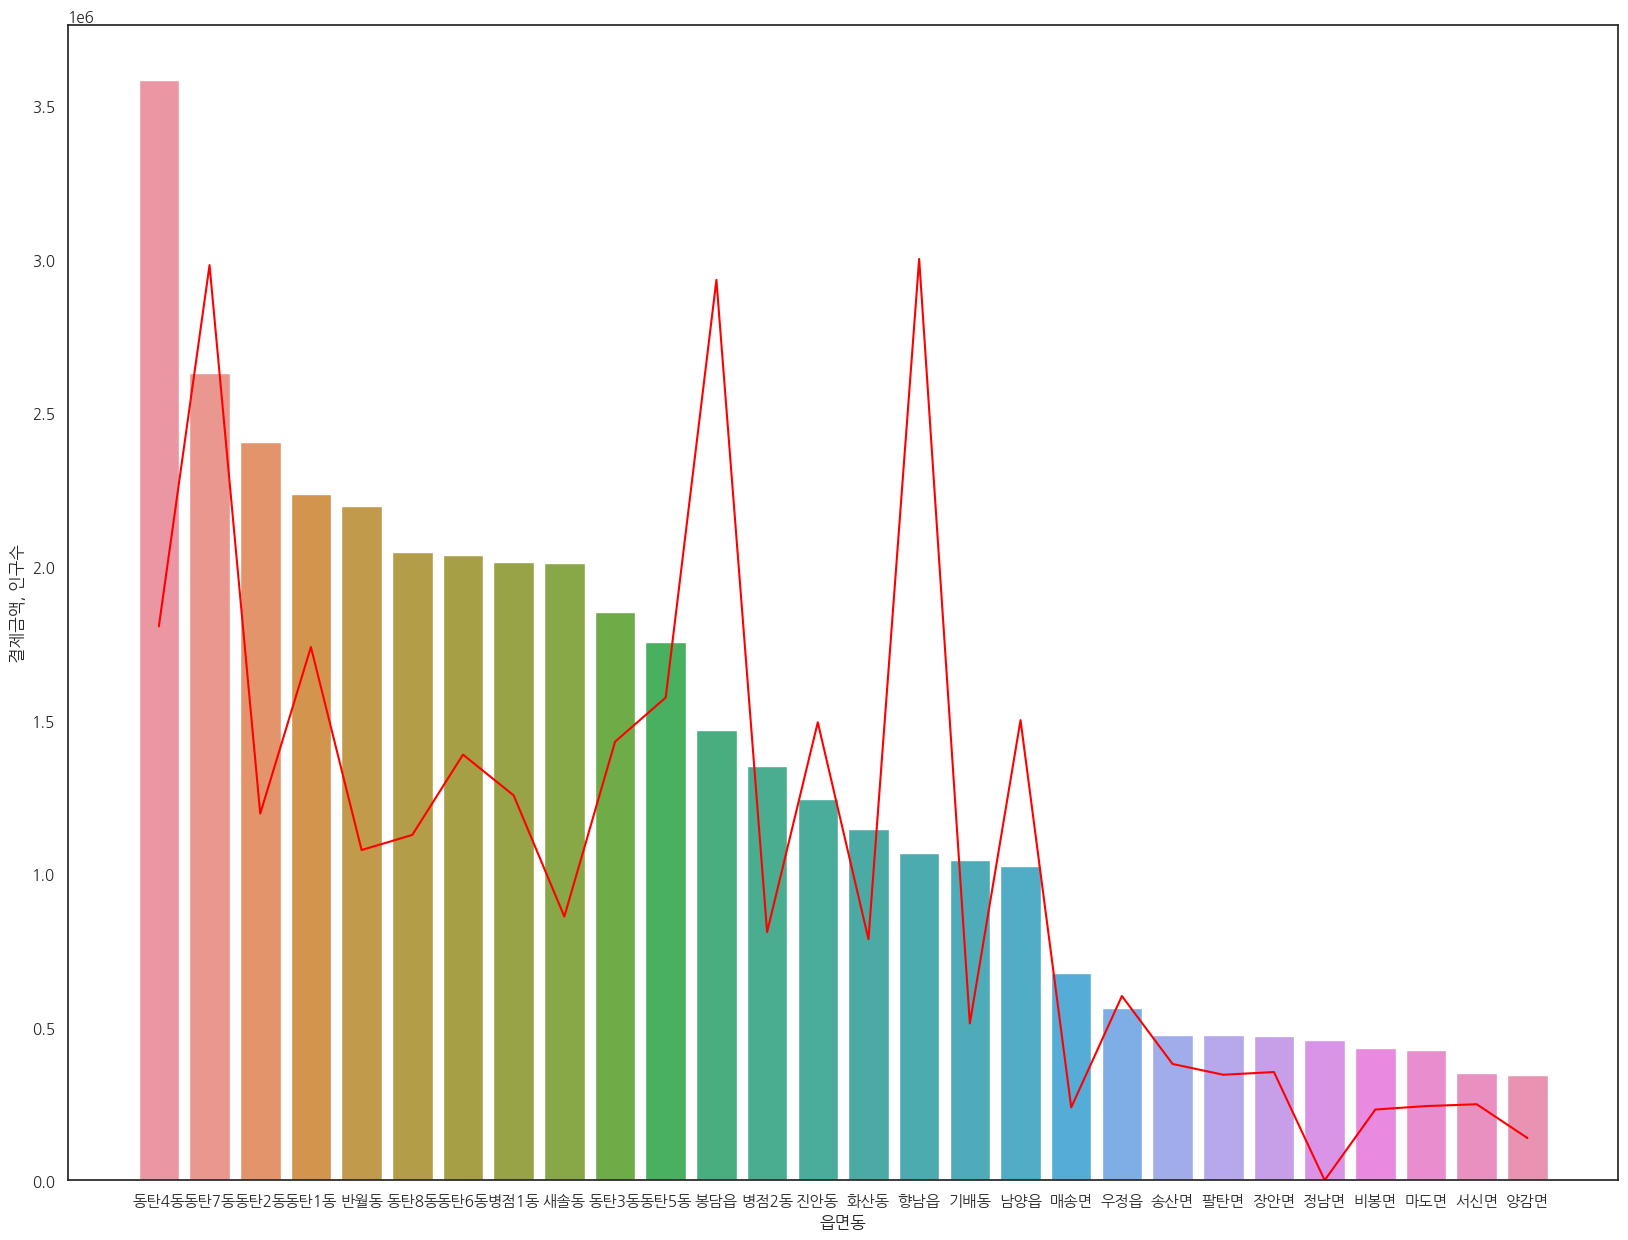

In [48]:
#  2022년 평균인원 , 평균걀제금액 동시 시각화


per_m22 = pd.merge(연도별22,avg_per, how='outer',on='읍면동')
per_m22.fillna(0)
per_m22 = per_m22.sort_values(by = '결제금액' , ascending = False)
per_m22

fig,ax= plt.subplots( figsize=(20, 15), dpi=100)
sns.barplot(data = per_m22, x = '읍면동' , y = '결제금액')
sns.lineplot(data = per_m22, x = '읍면동' , y = '2022평균인원',color = 'red')
ax.set_ylabel('결제금액, 인구수')


# 지역별 연령별 결제금액 시각화

In [49]:
지역화폐결제데이터합산_age = 지역화폐결제데이터합산.copy()
지역화폐결제데이터합산_age['읍면동'].str.contains('동탄')

지역화폐결제데이터합산_age['읍면동'] = 지역화폐결제데이터합산_age['읍면동'].apply(lambda x : '동탄' if '동탄' in x else x)

#각 연도별 데이터로 데이터프레임 분리


매출19=지역화폐결제데이터합산_age[지역화폐결제데이터합산_age['연도별']==2019]
매출20=지역화폐결제데이터합산_age[지역화폐결제데이터합산_age['연도별']==2020]
매출21=지역화폐결제데이터합산_age[지역화폐결제데이터합산_age['연도별']==2021]
매출22=지역화폐결제데이터합산_age[지역화폐결제데이터합산_age['연도별']==2022]

#22년 데이터에서 test 데이터 분리
매출22=매출22[매출22['train_test']=='train']

#각 연도별 평균매출을 담은 money 데이터프레임 생성
#22년 데이터는 10월까지 포함(train 데이터)

money_2019=list(매출19.groupby(['읍면동'])['결제금액'].mean().values)
money_2020=list(매출20.groupby(['읍면동'])['결제금액'].mean().values)
money_2021=list(매출21.groupby(['읍면동'])['결제금액'].mean().values)
money_2022=list(매출22.groupby(['읍면동'])['결제금액'].mean().values)



mdf_2019=pd.DataFrame(money_2019,매출19.groupby(['읍면동'])['결제금액'].mean().index,columns =['money'])
mdf_2020=pd.DataFrame(money_2020,매출20.groupby(['읍면동'])['결제금액'].mean().index,columns =['money'])
mdf_2021=pd.DataFrame(money_2021,매출21.groupby(['읍면동'])['결제금액'].mean().index,columns =['money'])
mdf_2022=pd.DataFrame(money_2022,매출22.groupby(['읍면동'])['결제금액'].mean().index,columns =['money'])

In [51]:
#화성시 평균연령 데이터

화성시 = pd.read_csv('화성시 연도별 평균연령.csv', encoding='utf-8')

# csv 파일에 존재하는 결측치 열, 행 제거

화성시 = 화성시.drop(화성시.columns[31:], axis=1)

#열 이름에 있는 공백 제거

cn=[]

for v in 화성시.columns:
    cn.append(v.replace(" " , ""))
    
화성시.columns =cn



In [52]:
###동탄 n동 => 각 동의 평균 연령의 평균값으로 대치한 '동탄' 열 생성

동탄=[] 

for i,v in enumerate(화성시['동탄1동']):
    if i <= 11:
        동탄.append((화성시['동탄1동'][i]+화성시['동탄2동'][i]+화성시['동탄3동'][i]+화성시['동탄4동'][i])/4)
    elif 11 < i <= 29:
        동탄.append((화성시['동탄1동'][i]+화성시['동탄2동'][i]+화성시['동탄3동'][i]+화성시['동탄4동'][i]+화성시['동탄5동'][i]+화성시['동탄6동'][i])/6)
    elif 29 <i <= 32:
        동탄.append((화성시['동탄1동'][i]+화성시['동탄2동'][i]+화성시['동탄3동'][i]+화성시['동탄4동'][i]+화성시['동탄5동'][i]+화성시['동탄6동'][i]+화성시['동탄7동'][i])/7)
    else:
        동탄.append((화성시['동탄1동'][i]+화성시['동탄2동'][i]+화성시['동탄3동'][i]+화성시['동탄4동'][i]+화성시['동탄5동'][i]+화성시['동탄6동'][i]+화성시['동탄7동'][i]+화성시['동탄8동'][i])/8)
        
화성시['동탄']=동탄

## copy파일 생성 및 화성시, 동탄 n동 열 삭제

화성시_copy=화성시

화성시_copy=화성시_copy.drop(['화성시','동탄면','동탄1동','동탄2동','동탄3동','동탄4동','동탄5동','동탄6동','동탄7동','동탄8동'],axis=1)

###각 데이터의 연도를 표시하는 '연도' 열 생성


연도=[]

for i,v in enumerate(화성시_copy['연월']):
    연도.append(int(화성시_copy['연월'][i][:4]))

화성시_copy['연도']=연도





##분석에 사용할 2019년 ~ 2022년 10월 데이터 선택
화성시_copy=화성시_copy[화성시_copy['연도']>=2019]
화성시_copy = 화성시_copy[:-2]



## 시각화에 사용하지 않는 column들 삭제

화성시_copy.columns
xx= 화성시_copy.drop(['연월','연도'], axis=1)

In [53]:
##각 연도별 평균연령을 계산, 리스트에 저장


xxx=xx.columns

age_2019=[]
age_2020=[]
age_2021=[]
age_2022=[]



for ii, vv in enumerate(xxx):
    age_2019.append(화성시_copy.groupby(['연도'])[vv].mean()[2019])
    age_2020.append(화성시_copy.groupby(['연도'])[vv].mean()[2020])
    age_2021.append(화성시_copy.groupby(['연도'])[vv].mean()[2021])
    age_2022.append(화성시_copy.groupby(['연도'])[vv].mean()[2022])
    
    


##각 연도별 평균연령, 평균매출을 담은 데이터프레임 생성

df_2019=pd.DataFrame(age_2019,xxx,columns =['age'])
df_2019['money']=mdf_2019
df_2019=df_2019.sort_values('money', ascending=False)


df_2020=pd.DataFrame(age_2020,xxx,columns =['age'])
df_2020['money']=mdf_2020
df_2020=df_2020.sort_values('money', ascending=False)

df_2021=pd.DataFrame(age_2021,xxx,columns =['age'])
df_2021['money']=mdf_2021
df_2021=df_2021.sort_values('money', ascending=False)

df_2022=pd.DataFrame(age_2022,xxx,columns =['age'])
df_2022['money']=mdf_2022
df_2022=df_2022.sort_values('money', ascending=False)

Text(0.5, 1.0, '2022')

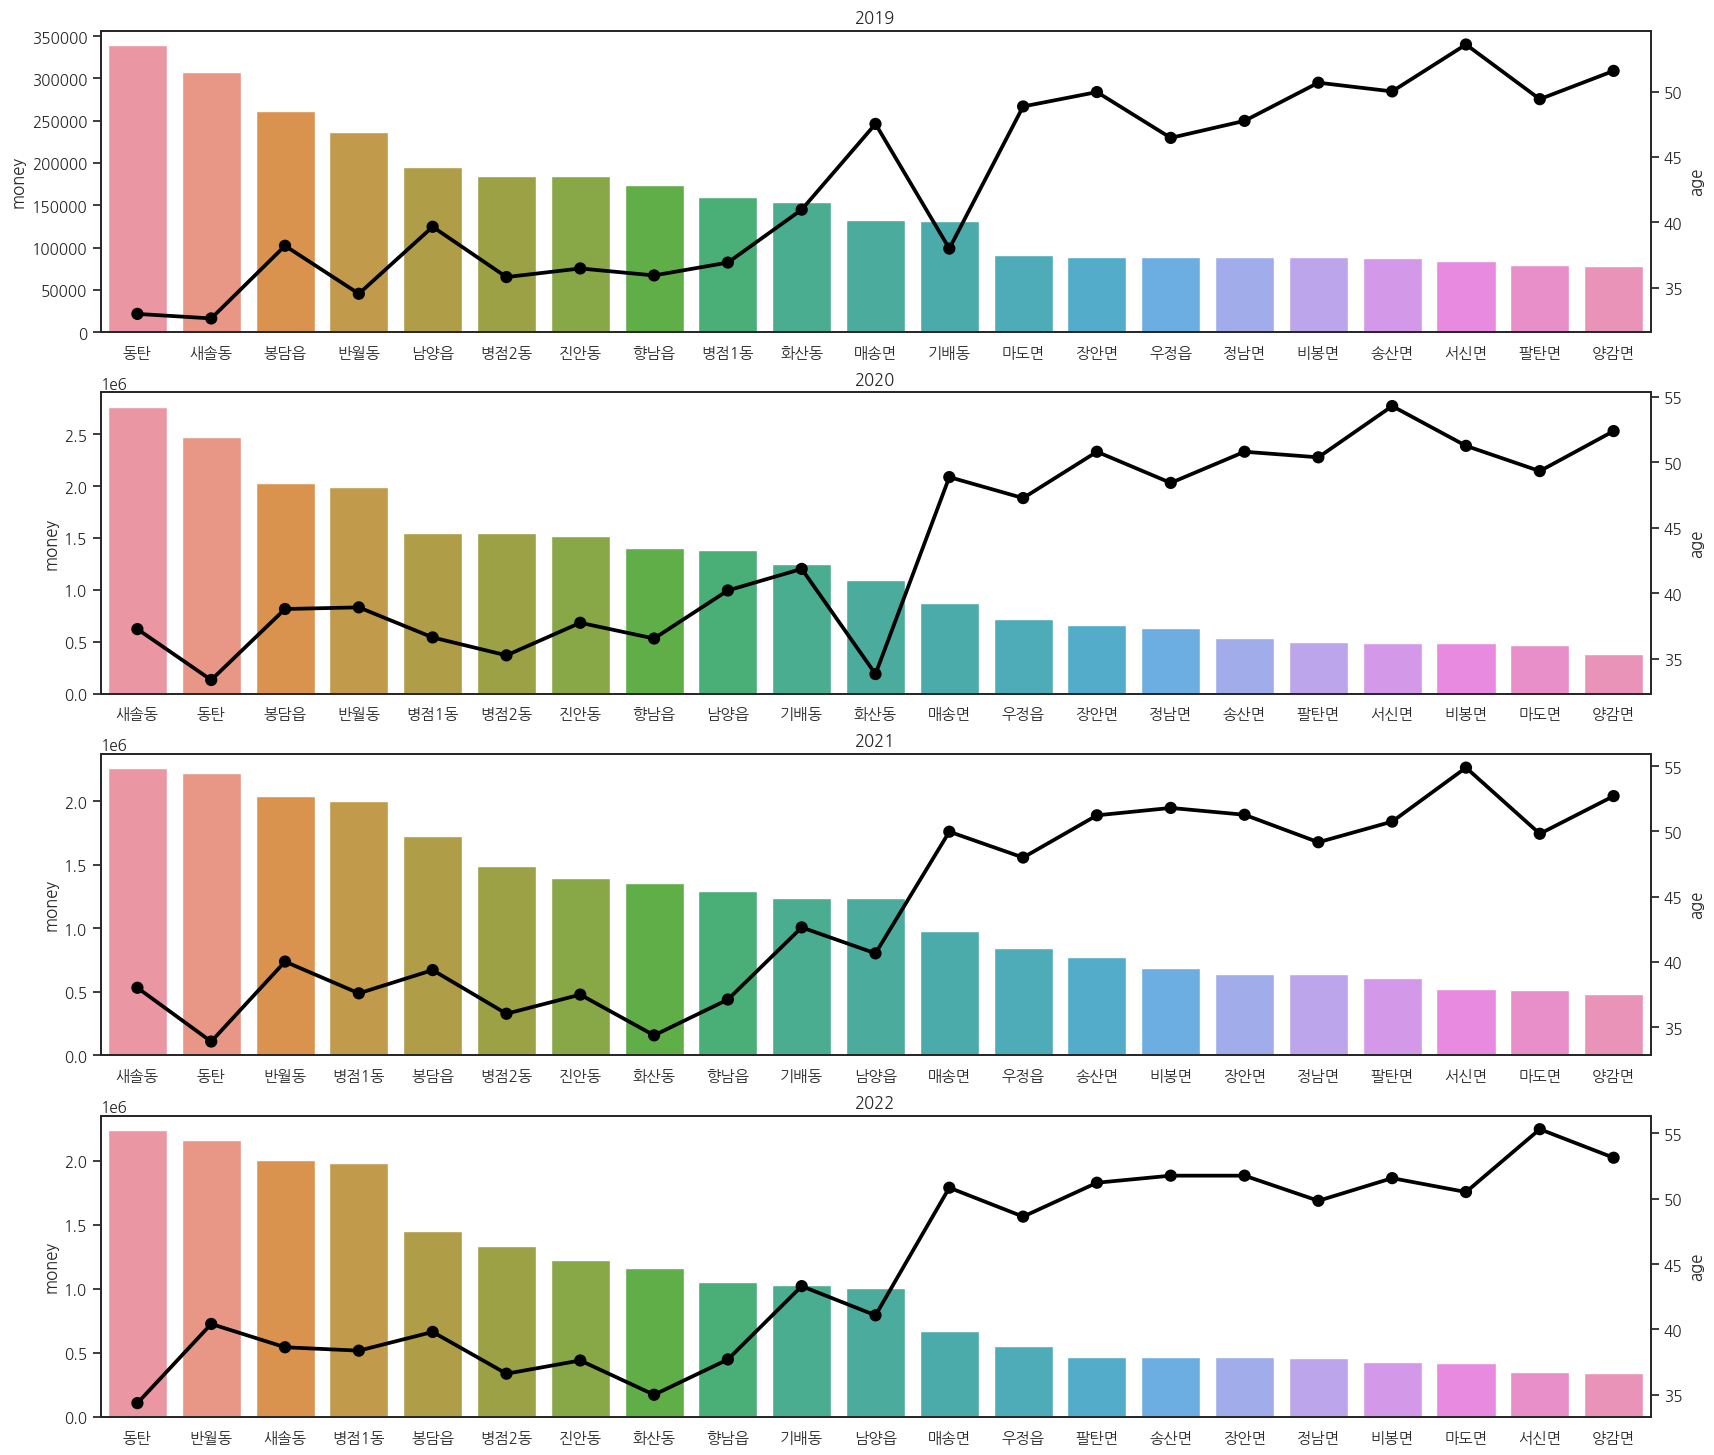

In [54]:
#각 데이터 프레임 seaborn으로 시각화


import seaborn as sns
import matplotlib.pyplot as plt




plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", 
rc={"axes.unicode_minus":False}, style='white')


fig, axs = plt.subplots(nrows= 4, figsize=(20,18))



ax0=sns.barplot(x=df_2019.index, y=df_2019['money'], ax=axs[0])
ax00=axs[0].twinx()
ax00=sns.pointplot(x=df_2019.index, y=df_2019['age'], color='black', ax=ax00)
ax0.set_title("2019")

ax1=sns.barplot(x=df_2020.index, y=df_2020['money'], ax=axs[1])
ax11=axs[1].twinx()
ax11=sns.pointplot(x=df_2020.index, y=df_2020['age'], color='black', ax=ax11)
ax1.set_title("2020")

ax2=sns.barplot(x=df_2021.index, y=df_2021['money'], ax=axs[2])
ax22=axs[2].twinx()
ax22=sns.pointplot(x=df_2021.index, y=df_2021['age'], color='black', ax=ax22)
ax2.set_title("2021")

ax3=sns.barplot(x=df_2022.index, y=df_2022['money'], ax=axs[3])
ax33=axs[3].twinx()
ax33=sns.pointplot(x=df_2022.index, y=df_2022['age'], color='black', ax=ax33)
ax3.set_title("2022")

Text(0.5, 1.0, '하위지역점포수 상위 5개 분야')

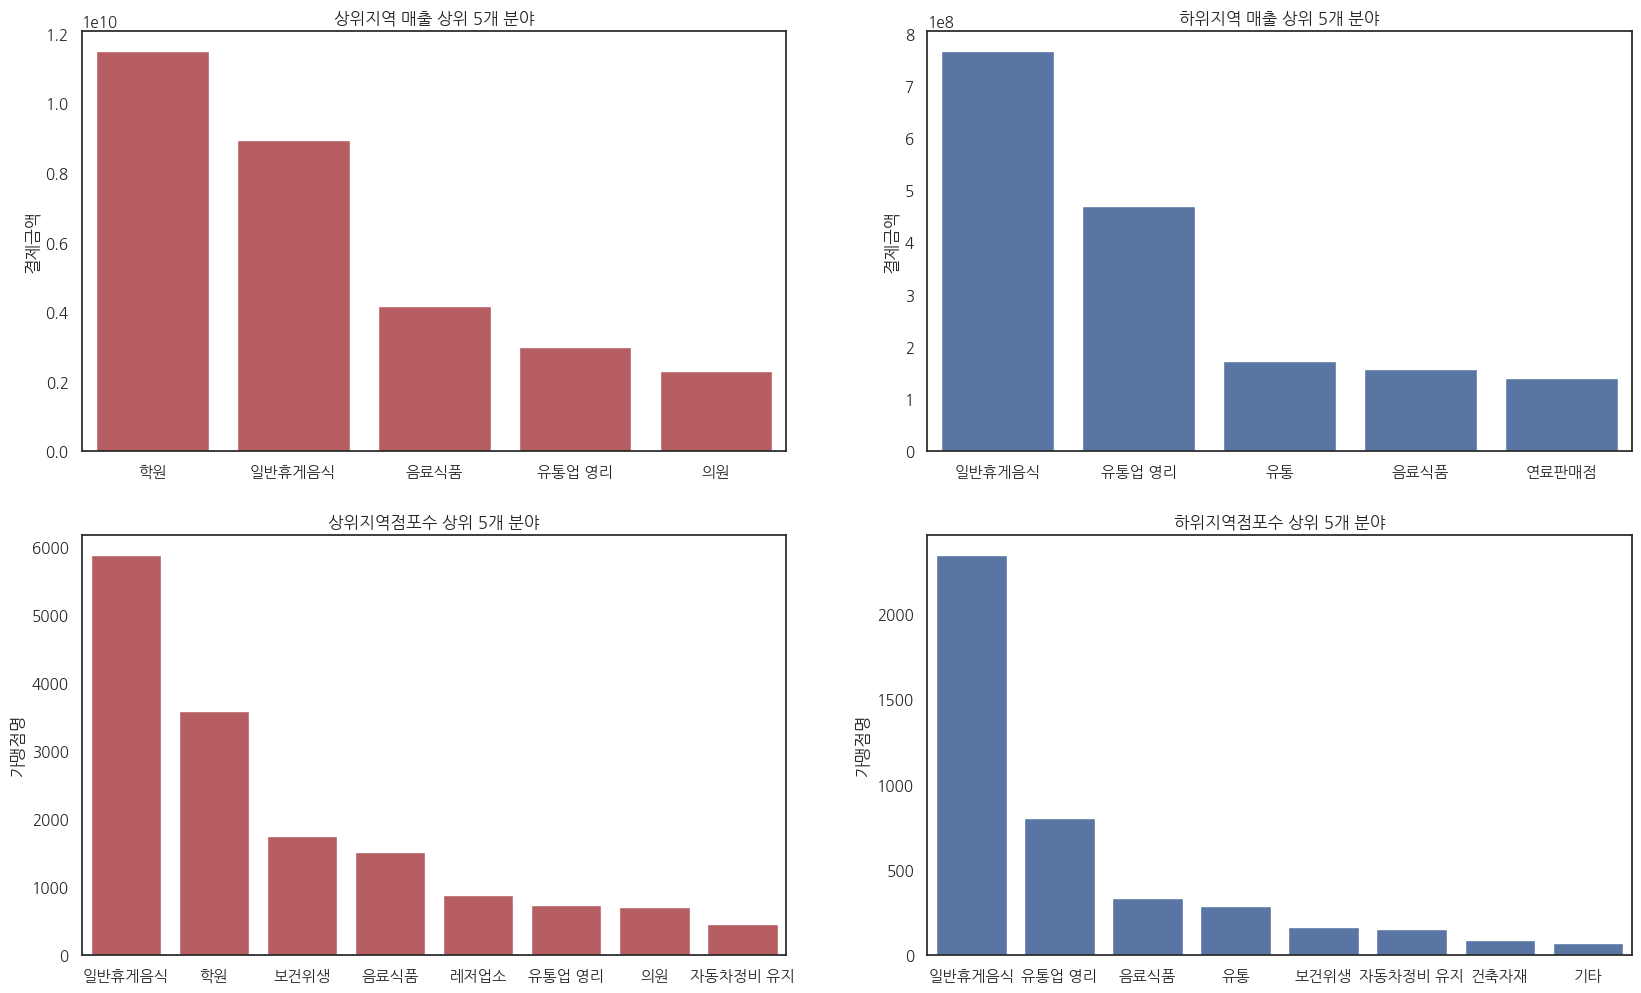

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

#2022년 지역화폐 매출 상위/하위 구역 구별

지역화폐결제데이터합산_2022_train=지역화폐결제데이터합산[ (지역화폐결제데이터합산['연도별']>=2022) & (지역화폐결제데이터합산['train_test']=='train' )]

상위=['동탄','반월동','병점1동','새솔동']
하위=['비봉면','마도면','서산면','양감면']

goodcity=지역화폐결제데이터합산_2022_train[지역화폐결제데이터합산_2022_train['읍면동'].isin(상위)]


badcity=지역화폐결제데이터합산_2022_train[지역화폐결제데이터합산_2022_train['읍면동'].isin(하위)]
            


#대분류명을 기준으로 결제금액의 총합 그룹화

aa=goodcity.groupby(['대분류명'])['결제금액'].sum()
ad=pd.DataFrame(aa).sort_values('결제금액', ascending=False).head()


bb=badcity.groupby(['대분류명'])['결제금액'].sum()
bd=pd.DataFrame(bb).sort_values('결제금액', ascending=False).head()

#대분류명을 기준으로 가맹점 수 그룹화

ab=goodcity.groupby(['대분류명'])['가맹점명'].count()
ac=pd.DataFrame(ab).sort_values('가맹점명', ascending=False).head(8)

ba=badcity.groupby(['대분류명'])['가맹점명'].count()
bc=pd.DataFrame(ba).sort_values('가맹점명', ascending=False).head(8)

#각 구역 별 매출 지분 상위 5개 분야 시각화
#각 구역 별 점포 수 상위 5개 분야 시각화



plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", 
rc={"axes.unicode_minus":False}, style='white')


fig, axs = plt.subplots(ncols= 2,nrows=2, figsize=(20,12))

ax0=sns.barplot(x=list(ad.index), y=ad['결제금액'], ax=axs[0,0], color='r')
ax0.set_title("상위지역 매출 상위 5개 분야")

ax1=sns.barplot(x=list(bd.index), y=bd['결제금액'], ax=axs[0,1], color='b')
ax1.set_title("하위지역 매출 상위 5개 분야")

ax2=sns.barplot(x=list(ac.index), y=ac['가맹점명'], ax=axs[1,0], color='r')
ax2.set_title("상위지역점포수 상위 5개 분야")

ax3=sns.barplot(x=list(bc.index), y=bc['가맹점명'], ax=axs[1,1], color='b')
ax3.set_title("하위지역점포수 상위 5개 분야")


# 머신러닝에 이용할 칼럼 추가

해당 모델은 시계열 문제이므로 슬라이딩 윈도우 기법을 이용하여 칼럼을 생성 

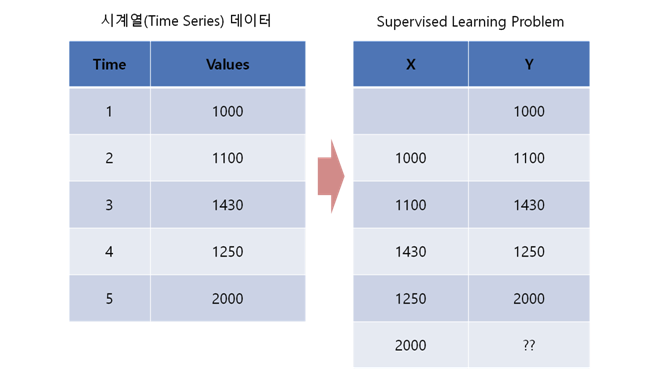

In [56]:
# 슬라이딩 윈도우 적용을 위한 함수 생성

def shift(data,col1,col2):
    result = []
    
    for x in data[col1].unique():
        sub = data[data[col1] == x ]
        shifted = sub[col2].shift(1)
        result.append(shifted)
        
    shifted_finish = pd.concat(result,axis=0)
    shifted_finish = shifted_finish.dropna()
    
    return shifted_finish

## 각 지역별 평균나이 칼럼 추가

In [57]:
화성시

,연월,화성시,봉담읍,우정읍,향남읍,남양읍,매송면,비봉면,마도면,송산면,...,화산동,동탄1동,동탄2동,동탄3동,동탄4동,동탄5동,동탄6동,동탄7동,동탄8동,동탄
0,2017년01월,36.10,36.50,44.20,34.70,39.60,44.70,49.00,47.20,48.20,...,39.00,31.90,32.70,31.40,31.10,NaN,NaN,NaN,NaN,31.77
1,2017년02월,36.10,36.40,44.30,34.80,39.60,44.80,49.10,47.30,48.30,...,39.10,32.00,32.80,31.50,31.10,NaN,NaN,NaN,NaN,31.85
2,2017년03월,36.10,36.30,44.40,34.80,39.70,44.90,49.20,47.30,48.20,...,39.20,32.00,32.80,31.60,31.20,NaN,NaN,NaN,NaN,31.90
3,2017년04월,36.10,36.40,44.40,34.80,39.70,44.90,49.30,47.40,48.30,...,39.20,32.10,32.80,31.60,31.20,NaN,NaN,NaN,NaN,31.93
4,2017년05월,36.20,36.40,44.50,34.90,39.70,45.00,49.30,47.40,48.40,...,39.30,32.10,32.90,31.70,31.30,NaN,NaN,NaN,NaN,32.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022년08월,38.30,39.90,48.70,37.80,41.20,51.00,51.50,50.60,51.90,...,35.10,36.40,34.90,33.20,35.70,34.40,34.20,33.50,33.50,34.48
68,2022년09월,38.30,40.00,48.70,37.90,41.20,51.10,51.50,50.70,52.00,...,35.20,36.50,35.00,33.30,35.70,34.50,34.20,33.60,33.60,34.55
69,2022년10월,38.40,40.00,48.80,38.00,41.20,51.20,51.50,50.90,52.10,...,35.30,36.60,35.10,33.30,35.80,34.50,34.10,33.60,33.60,34.58
70,2022년11월,38.40,40.00,48.90,38.00,41.20,51.20,51.50,51.00,52.20,...,35.30,36.60,35.10,33.40,35.80,34.50,34.10,33.60,33.60,34.59


In [58]:
#연월 column에 있는 한글 삭제 및 int형으로 반환
화성시['연월']=화성시['연월'].str.replace(pat=r'[ㄱ-ㅣ가-힣]+', repl= r'', regex=True).astype('int')



#column 인덱스를 데이터로 변환(1행)
나이 = pd.melt(화성시, id_vars=['연월'],value_vars=['봉담읍', '우정읍', '향남읍', '남양읍', '매송면', '비봉면', '마도면', '송산면',
       '서신면', '팔탄면', '장안면', '양감면', '정남면', '새솔동', '진안동', '병점1동', '병점2동',
       '반월동', '기배동', '화산동', '동탄1동', '동탄2동', '동탄3동', '동탄4동', '동탄5동', '동탄6동',
       '동탄7동', '동탄8동'])



#사용할 데이터인 2019년4월 이후 데이터 선택
나이 = 나이[나이['연월']>=201904]


In [59]:
# 동탄7동 8동에 있는 결측값을 근접한 월의 평균나이로 대체

나이.loc[나이['variable'] == '동탄8동', 'value'] = 나이.loc[나이['variable'] == '동탄8동', 'value'].fillna(0)
나이.loc[나이['variable'] == '동탄7동', 'value'] = 나이.loc[나이['variable'] == '동탄7동', 'value'].fillna(0)

In [60]:
# 칼럼 이름 변경

나이 = 나이.rename(columns = {'variable':'읍면동','value':'평균나이','연월':'월별'})

In [61]:
# 앞서 정의한 shift 함수 적용

나이['평균나이shift'] = shift(나이,'읍면동','평균나이')
나이 = 나이[나이['월별']>=201905].drop(columns = ['평균나이'])
나이

,월별,읍면동,평균나이shift
28,201905,봉담읍,38.20
29,201906,봉담읍,38.20
30,201907,봉담읍,38.20
31,201908,봉담읍,38.30
32,201909,봉담읍,38.30
...,...,...,...
2011,202208,동탄8동,33.50
2012,202209,동탄8동,33.50
2013,202210,동탄8동,33.60
2014,202211,동탄8동,33.60


In [62]:
# 동탄 7동의 7월의 평균나이는 8월의 평균나이로 대체 , 동탄 8동의 10월의 평균나이는 11월의 평균나이로 대체 

나이.loc[(나이['읍면동'] == '동탄7동') & (나이['월별'] == 201907), '평균나이shift'] = 32.00
나이.loc[(나이['읍면동'] == '동탄8동') & (나이['월별'] == 201910), '평균나이shift'] = 33.10

In [63]:
# 지역화폐결제데이터합산 데이터에 나이 데이터 추가

지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.merge(나이,how='outer',on=['월별','읍면동'])

In [64]:
지역화폐결제데이터합산ver2

,index,월별,읍면동,월,연도별,결제금액,train_test,읍면동_인코딩,id,평균나이shift
0,2,201905,동탄1동,5,2019,298829042,train,0.00,0,33.30
1,28,201906,동탄1동,6,2019,507401001,train,0.00,1,33.30
2,54,201907,동탄1동,7,2019,615763281,train,0.00,2,33.40
3,81,201908,동탄1동,8,2019,766574130,train,0.00,3,33.40
4,108,201909,동탄1동,9,2019,749066359,train,0.00,4,33.40
...,...,...,...,...,...,...,...,...,...,...
1227,1088,202208,동탄2동,8,2022,6466800,train,27.00,1227,34.90
1228,1116,202209,동탄2동,9,2022,6834120,train,27.00,1228,34.90
1229,1144,202210,동탄2동,10,2022,7164300,train,27.00,1229,35.00
1230,1172,202211,동탄2동,11,2022,7933500,train,27.00,1230,35.10


### 평균나이 라벨링

In [65]:

# 데이터에서 평균나이 칼럼을 구간으로 나누기

지역화폐결제데이터합산ver2['평균나이_label'] = pd.cut(지역화폐결제데이터합산ver2['평균나이shift'], bins=10, labels=False)


## 인구수 칼럼 추가

In [66]:
인구 = pd.read_csv('201903_202212_주민등록인구및세대현황_월간.csv',encoding='cp949')

# 행정구역 이름 바꿔주기

인구 = 인구.rename(columns = {'행정구역':'읍면동'})

# 칼럼을 행으로 바꿔주기

인구 = 인구.melt(id_vars = '읍면동',value_vars = 인구.columns[1:])

# 월별과 구분자 만들기

def 월별만들기(x) : 
    result = []
    for i in x:
        z = i[0:8].replace('년','')
        z = z.replace('월','')
        result.append(z)
    return result

def 구분자만들기(x) : 
    result = []
    for i in x:
        z = i[9:]
        result.append(z)
    return result

인구['월별'] = 월별만들기(인구['variable'])
인구['구분'] = 구분자만들기(인구['variable'])


인구['월별'] = 인구['월별'].astype('int')



# 구분 칼럼에 있는 값들을 칼럼으로 바꿔주고 지역화폐결제데이터합산ver2와 merge 해주기

인구 = 인구.pivot_table(index=['월별','읍면동'], columns=['구분'], values='value', aggfunc='first').reset_index()



# 각 칼럼들을 학습에 이용하기 위해 쉼표 지우기 및 float타입으로 바꿔주기

columns_to_process = ['총인구수']
인구[columns_to_process] = 인구[columns_to_process].replace(',', '', regex=True).astype(float)


인구 = 인구[['월별','읍면동','총인구수']]

# 앞서 정의한 shift 함수 적용

인구['총인구수_shift'] = shift(인구,'읍면동','총인구수')
인구 = 인구[인구['월별']>=201905].drop(columns = ['총인구수'])


# 동탄 7동의 7월의 총인구수shift는 7월의 인구로 대체 , 동탄 8동의 10월의 총인구수shift는 11월의 인구로 대체 

인구.loc[(인구['읍면동'] == '동탄7동') & (인구['월별'] == 201907), '총인구수_shift'] = 68279.00
인구.loc[(인구['읍면동'] == '동탄8동') & (인구['월별'] == 201910), '총인구수_shift'] = 19012.00
    

# 지역화폐결제데이터합산ver2와 merge

지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.merge(인구, how='outer', on=['월별', '읍면동'])



                

### 인구수 라벨링

In [67]:
# 데이터에서 총인구수 칼럼을 10개 구간으로 나누는 기준 생성
지역화폐결제데이터합산ver2['총인구수_label'] = pd.cut(지역화폐결제데이터합산ver2['총인구수_shift'], bins=10, labels=False)

## 상점수 칼럼 추가

In [68]:
# 월별로 거래가 된 가맹점수 칼럼 추가

월거래가맹점수 = 지역화폐결제데이터합산.groupby(['월별','읍면동'])['사업자번호'].count().reset_index()

월거래가맹점수 = 월거래가맹점수.rename(columns = {'사업자번호' : '월거래가맹점수'})

# 사전에 정의된 shift 함수 적용

월거래가맹점수['월거래가맹점수_shift'] = shift(월거래가맹점수,'읍면동','월거래가맹점수')
월거래가맹점수 = 월거래가맹점수[월거래가맹점수['월별']>=201905].drop(columns = ['월거래가맹점수'])


지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.merge(월거래가맹점수,how='outer',on=['월별','읍면동'])

지역화폐결제데이터합산ver2['월거래가맹점수_shift'] = 지역화폐결제데이터합산ver2['월거래가맹점수_shift'].fillna(0)

In [69]:
# 대분류명이 '학원'인 가맹점의 개수 계산
학원_거래가맹점수 = 지역화폐결제데이터합산[지역화폐결제데이터합산['train_test'] == 'train']
학원_거래가맹점수 = 학원_거래가맹점수[학원_거래가맹점수['대분류명'] == '학원']
학원_거래가맹점수 = 학원_거래가맹점수.groupby(['월별', '읍면동'])['사업자번호'].count().reset_index()
학원_거래가맹점수 = 학원_거래가맹점수.rename(columns={'사업자번호': '학원_거래가맹점수'})


# 사전에 정의된 shift 함수 적용

학원_거래가맹점수['학원_거래가맹점수_shift'] = shift(학원_거래가맹점수,'읍면동','학원_거래가맹점수')

학원_거래가맹점 = 학원_거래가맹점수

학원_거래가맹점수 = 학원_거래가맹점수[학원_거래가맹점수['월별']>=201905].drop(columns = ['학원_거래가맹점수'])

# 지역화폐결제데이터합산ver2에 학원 거래가맹점수 열 추가
지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.merge(학원_거래가맹점수, how='outer', on=['월별', '읍면동'])

# 학원 거래가 없었던 지역에 대해서 0으로 채우기

지역화폐결제데이터합산ver2['학원_거래가맹점수_shift'] = 지역화폐결제데이터합산ver2['학원_거래가맹점수_shift'].fillna(0)

In [70]:
지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.sort_values(by = 'id')

## 읍면동별 월별 평균나이별 클러스터

In [71]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def cluster_data(data, column_name,column_name2,num):
    grouped_data = data.groupby(column_name)[column_name2].mean()
    arr = grouped_data.to_numpy().reshape(-1, 1)

    k = num
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(arr)

    sort_order = np.argsort(kmeans.cluster_centers_.flatten())

    labels = np.zeros_like(kmeans.labels_)
    for i, cluster in enumerate(sort_order):
        labels[kmeans.labels_ == cluster] = i

    clustered_data = pd.DataFrame({column_name: grouped_data.index, column_name+ column_name2 + '_cluster': labels})
    
    
    return clustered_data

train = 지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['train_test']=='train']

# '읍면동별가격' 클러스터링 적용
neighborhood_clustered_data = cluster_data(train, '읍면동','결제금액',15)
지역화폐결제데이터합산ver2 = pd.merge(지역화폐결제데이터합산ver2, neighborhood_clustered_data, how='left', on='읍면동')

# '월별가격클러스터' 클러스터링 적용
monthly_clustered_data = cluster_data(train, '월','결제금액',6)
지역화폐결제데이터합산ver2 = pd.merge(지역화폐결제데이터합산ver2, monthly_clustered_data, how='left', on='월')


# # '읍면동거래량클러스터' 클러스터링 적용
# monthly_clustered_data = cluster_data(train, '평균나이_label','log_price',8)
# 지역화폐결제데이터합산ver2 = pd.merge(지역화폐결제데이터합산ver2, monthly_clustered_data, how='left', on='평균나이_label')





# # 클러스터링 결과 확인
# print(지역화폐결제데이터합산ver2['읍면동log_price_cluster'].value_counts())
# print(지역화폐결제데이터합산ver2['월log_price_cluster'].value_counts())
# print(지역화폐결제데이터합산ver2['읍면동log_거래량_cluster'].value_counts())
# print(지역화폐결제데이터합산ver2['월log_거래량_cluster'].value_counts())



## 지역화폐결제데이터 test 정답지 저장
## test에 해당하는 부분 결제금액을 nan 값으로 변경

In [72]:
지역화폐결제데이터합산ver2 = 지역화폐결제데이터합산ver2.sort_values(by='id')
# 원본 데이터 저장

원본 = 지역화폐결제데이터합산ver2.copy()

In [73]:
지역화폐결제데이터합산_test = pd.DataFrame(지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['train_test']=='test']['결제금액'])


for i,j in enumerate(지역화폐결제데이터합산ver2['train_test']) :
    if 지역화폐결제데이터합산ver2['train_test'][i] == 'train':
        pass
    else :
        지역화폐결제데이터합산ver2.loc[i,'결제금액'] = np.nan
        지역화폐결제데이터합산ver2.loc[i,'log_price'] = np.nan
        

In [74]:
지역화폐결제데이터합산ver2.info()
지역화폐결제데이터합산ver2.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 0 to 1231
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            1232 non-null   int64  
 1   월별               1232 non-null   int64  
 2   읍면동              1232 non-null   object 
 3   월                1232 non-null   int64  
 4   연도별              1232 non-null   int64  
 5   결제금액             1204 non-null   float64
 6   train_test       1232 non-null   object 
 7   읍면동_인코딩          1232 non-null   float64
 8   id               1232 non-null   int64  
 9   평균나이shift        1232 non-null   float64
 10  평균나이_label       1232 non-null   int64  
 11  총인구수_shift       1232 non-null   float64
 12  총인구수_label       1232 non-null   int64  
 13  월거래가맹점수_shift    1232 non-null   float64
 14  학원_거래가맹점수_shift  1232 non-null   float64
 15  읍면동결제금액_cluster  1232 non-null   int32  
 16  월결제금액_cluster    1232 non-null   int32  
 17  log_price     

Index(['index', '월별', '읍면동', '월', '연도별', '결제금액', 'train_test', '읍면동_인코딩', 'id',
       '평균나이shift', '평균나이_label', '총인구수_shift', '총인구수_label', '월거래가맹점수_shift',
       '학원_거래가맹점수_shift', '읍면동결제금액_cluster', '월결제금액_cluster', 'log_price'],
      dtype='object')

## 각 학습에 사용할 칼럼 상관계수 구하기

In [75]:
!pip install category_encoders
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 4.1 MB/s eta 0:00:00


In [76]:

# 학습에 사용할 columns 선정

columns_corr = [ '결제금액','월', '연도별', '결제금액', '읍면동_인코딩', 'id',
       '평균나이shift', '평균나이_label', '총인구수_shift', '총인구수_label', '월거래가맹점수_shift','학원_거래가맹점수_shift']



columns1 = ['읍면동log_price_cluster','log_총인구수_labels','월','연도별','연도거래가맹점수','가맹점수','학원_거래가맹점수','학원월_거래가맹점수']

columns = ['읍면동_인코딩','월', '연도별','평균나이shift', '총인구수_shift', '월거래가맹점수_shift','총인구수_label', '평균나이_label','월별','읍면동결제금액_cluster', '월결제금액_cluster']

# 각 columns 별 상관계수

지역화폐결제데이터합산ver2[columns_corr].corr()


# 머신러닝 학습

,결제금액,월,연도별,결제금액,읍면동_인코딩,id,평균나이shift,평균나이_label,총인구수_shift,총인구수_label,월거래가맹점수_shift,학원_거래가맹점수_shift
결제금액,1.00,-0.01,0.22,1.00,-0.68,-0.67,-0.37,-0.35,0.60,0.58,0.82,0.85
월,-0.01,1.00,-0.17,-0.01,-0.00,0.00,0.01,0.01,0.00,0.00,0.02,-0.01
연도별,0.22,-0.17,1.00,0.22,0.00,0.03,0.11,0.12,0.05,0.06,0.21,0.22
결제금액,1.00,-0.01,0.22,1.00,-0.68,-0.67,-0.37,-0.35,0.60,0.58,0.82,0.85
읍면동_인코딩,-0.68,-0.00,0.00,-0.68,1.00,1.00,0.60,0.58,-0.76,-0.75,-0.80,-0.76
id,-0.67,0.00,0.03,-0.67,1.00,1.00,0.60,0.59,-0.75,-0.74,-0.79,-0.75
평균나이shift,-0.37,0.01,0.11,-0.37,0.60,0.60,1.00,0.98,-0.59,-0.60,-0.34,-0.47
평균나이_label,-0.35,0.01,0.12,-0.35,0.58,0.59,0.98,1.00,-0.58,-0.60,-0.32,-0.45
총인구수_shift,0.60,0.00,0.05,0.60,-0.76,-0.75,-0.59,-0.58,1.00,0.99,0.71,0.68
총인구수_label,0.58,0.00,0.06,0.58,-0.75,-0.74,-0.60,-0.60,0.99,1.00,0.69,0.66


In [77]:
지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['학원_거래가맹점수_shift'] == 0]

,index,월별,읍면동,월,연도별,결제금액,train_test,읍면동_인코딩,id,평균나이shift,평균나이_label,총인구수_shift,총인구수_label,월거래가맹점수_shift,학원_거래가맹점수_shift,읍면동결제금액_cluster,월결제금액_cluster,log_price
43,1199,202212,동탄1동,12,2022,NaN,test,0.00,43,36.60,6,50887.00,4,2669.00,0.00,14,2,NaN
87,1212,202212,봉담읍,12,2022,NaN,test,1.00,87,40.00,7,87786.00,8,1910.00,0.00,13,2,NaN
131,1223,202212,향남읍,12,2022,NaN,test,2.00,131,38.00,6,87298.00,8,2161.00,0.00,11,2,NaN
132,1225,201905,동탄7동,5,2019,0.00,train,3.00,132,0.00,0,0.00,0,0.00,0.00,12,4,NaN
133,1226,201906,동탄7동,6,2019,0.00,train,3.00,133,0.00,0,0.00,0,0.00,0.00,12,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,3,201905,동탄2동,5,2019,1603700.00,train,27.00,1188,34.20,6,36223.00,3,4.00,0.00,0,4,NaN
1224,1004,202205,동탄2동,5,2022,14322100.00,train,27.00,1224,34.80,6,34942.00,3,9.00,0.00,0,4,NaN
1225,1032,202206,동탄2동,6,2022,10304100.00,train,27.00,1225,34.80,6,34955.00,3,6.00,0.00,0,3,NaN
1230,1172,202211,동탄2동,11,2022,7933500.00,train,27.00,1230,35.10,6,34857.00,3,4.00,0.00,0,3,NaN


# 머신러닝 학습

### validation 범위 설정

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold # StratifiedKFold
!pip install lightgbm
!pip install xgboost
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
import optuna


# val 범위 설정


validation_year_month = 202211

train = 지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['train_test'] == 'train']

train_x = train.loc[(train['월별'] < validation_year_month), columns]
train_y = train.loc[(train['월별'] < validation_year_month), '결제금액']

val_x = train.loc[(train['월별'] >= validation_year_month), columns]
val_y = train.loc[(train['월별'] >= validation_year_month), '결제금액']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 50.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 22.7 MB/s eta 0:00:0000:0100:01


## 시계열 모델

### Prophet 모델 적용

본래 1달 맞추기가 목표였지만 prophet은 그래프나 추세를 보기에는 1달로는 무리가 있다고 판단하여 화성시 전체의 지역화폐 매출 6달 맞추기로 변경

In [79]:
!pip install Prophet

  Using cached prophet-1.1.4-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.5/598.5 kB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 63.3 MB/s eta 0:00:0000:0100:01
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 45.8 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.2 MB/s e

In [80]:
from datetime import datetime, timedelta
# 데이터의 월별 column을 datetime 타입으로 변경하여 날짜 column 추가

지역화폐결제데이터합산ver2['날짜']=지역화폐결제데이터합산ver2['월별'].astype(int)
지역화폐결제데이터합산ver2['날짜']=pd.to_datetime(지역화폐결제데이터합산ver2['날짜'], format='%Y%m')

train = 지역화폐결제데이터합산ver2[지역화폐결제데이터합산ver2['월별'] <= 202206].groupby(['월별','날짜'])['결제금액'].sum().reset_index()

# 그래프로 결과 확인을 위한 화성시 원본 데이터 저장

데이터 = 원본.groupby(['월별'])['결제금액'].sum().reset_index()
데이터['날짜']=데이터['월별'].astype(int)
데이터['날짜']=pd.to_datetime(데이터['날짜'], format='%Y%m')


In [81]:

from prophet import Prophet
import pandas as pd


# 모델 함수로 정의하기


def predict(train, p, periods=6, freq='MS'):
    """
    Args:
        train (DataFrame): 학습 데이터 프레임
        p (dict): Prophet 모델의 하이퍼파라미터 설정을 담은 딕셔너리
        periods (int): 예측 기간 (기본값: 6)
        freq (str): 예측 주기 (기본값: 'MS')
    
    Returns:
        DataFrame: 예측 결과인 날짜와 예측값을 포함한 데이터프레임
    """
    df = pd.DataFrame()
    df['ds'] = train['날짜']
    df['y'] = train['결제금액']

    model = Prophet(**p)
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    forecast = model.predict(future)
    return forecast.loc[:, ['ds', 'yhat']]


### 하이퍼파라미터 적용 전 모델의 mae 확인

23:51:21 - cmdstanpy - INFO - Chain [1] start processing
23:51:21 - cmdstanpy - INFO - Chain [1] done processing


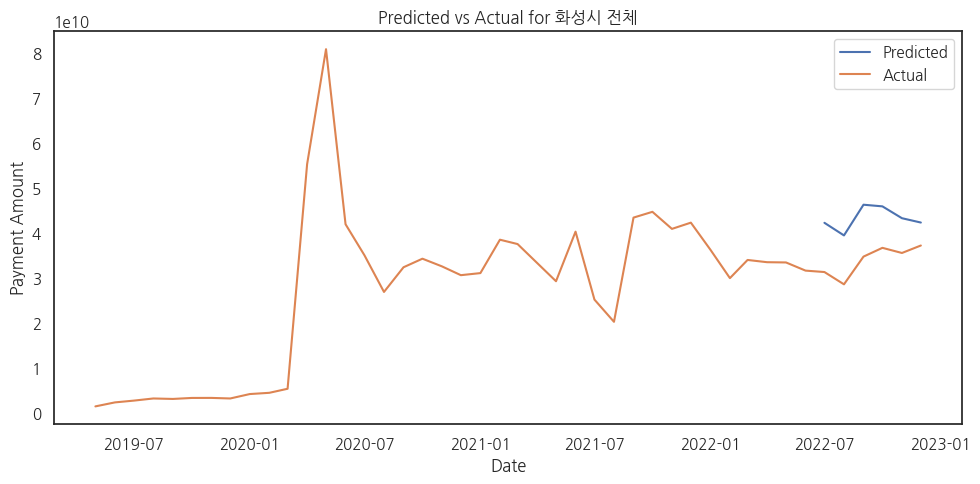

In [82]:
import matplotlib.pyplot as plt

# 예측을 위한 하이퍼파라미터 설정

hyperparameters = { }


# 화성시 전체 데이터 선택
target = predict(train, hyperparameters)
target.set_index('ds', inplace=True)
target = target['2022-07-01':]  # 2022년 7월 이후 데이터 선택

plt.figure(figsize=(10, 5))
sns.lineplot(x=target.index, y=target['yhat'], label='Predicted')
sns.lineplot(x=데이터['날짜'], y=데이터['결제금액'], label='Actual')

plt.title('Predicted vs Actual for 화성시 전체')
plt.xlabel('Date')
plt.ylabel('Payment Amount')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
from sklearn.metrics import mean_absolute_error
점수확인 = 원본[원본['월별']>=202207].groupby(['월별'])['결제금액'].sum().reset_index()


mean_absolute_error(점수확인['결제금액'], target['yhat'])

9231992933.721193

### 7월 이전 데이터 그래프와 예측 그래프를 보고 하이퍼파라미터 설정

23:51:22 - cmdstanpy - INFO - Chain [1] start processing
23:51:22 - cmdstanpy - INFO - Chain [1] done processing


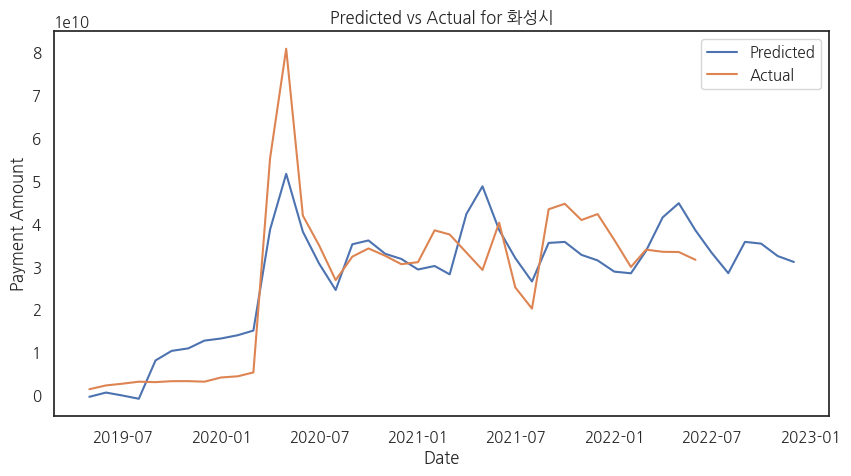

In [84]:


aa = train

# 예측을 위한 하이퍼파라미터 설정
hyperparameters = {
    'changepoint_range' : 0.8,
    'changepoint_prior_scale': 0.25,
    'seasonality_prior_scale' : 0.5,
    'seasonality_mode' : 'additive'
}

target = predict(aa, hyperparameters)

plt.figure(figsize=(10, 5))
sns.lineplot(x=target['ds'], y=target['yhat'], label='Predicted')
sns.lineplot(x=aa['날짜'], y=aa['결제금액'], label='Actual')
plt.title(f'Predicted vs Actual for 화성시')
plt.xlabel('Date')
plt.ylabel('Payment Amount')
plt.legend()
plt.show()


23:51:22 - cmdstanpy - INFO - Chain [1] start processing
23:51:22 - cmdstanpy - INFO - Chain [1] done processing


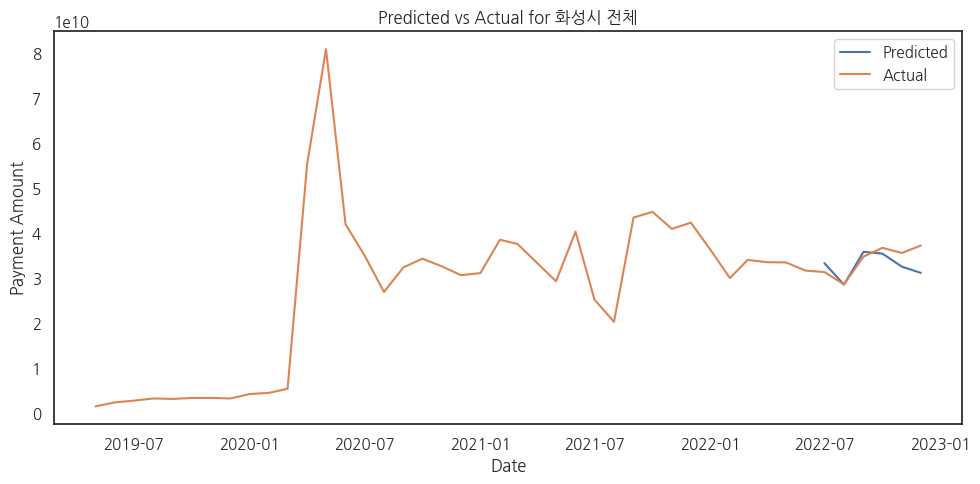

In [85]:
import matplotlib.pyplot as plt


# 화성시 전체 데이터 선택
target = predict(train, hyperparameters)
target.set_index('ds', inplace=True)
target = target['2022-07-01':]  # 2022년 7월 이후 데이터 선택

plt.figure(figsize=(10, 5))
sns.lineplot(x=target.index, y=target['yhat'], label='Predicted')
sns.lineplot(x=데이터['날짜'], y=데이터['결제금액'], label='Actual')

plt.title('Predicted vs Actual for 화성시 전체')
plt.xlabel('Date')
plt.ylabel('Payment Amount')
plt.legend()

plt.tight_layout()
plt.show()


### Prophet mae 확인

In [86]:
from sklearn.metrics import mean_absolute_error
점수확인 = 원본[원본['월별']>=202207].groupby(['월별'])['결제금액'].sum().reset_index()


mean_absolute_error(점수확인['결제금액'], target['yhat'])


2253087996.904024

## 그 외 모델 비교

해당 자료는 시계열 자료

일반 Kfold를 사용할 경우 섞인 값 중에 미래의 값으로 과거의 값을 예측할 가능성이 있다

성능은 좋게 나올 수 있으나, 실제로는 미래의 값을 사용할 수 없기 때문에 부적절하다고 판단

시계열자료에서 사용하는 TimeSeriesSplit 기법을 사용하고 폴드 수는 10folds 적용


총 10개의 폴드로 구분하여 앞에서 부터 끊어서 학습 및 검증
다음 폴드에선 이전의 폴드 데이터까지 이용하여 반복적으로 교차 검증
이 경우 미래의 값은 무조건 검증에 이용.(미래의 값이 학습에 이용되지 않음)



여러개의 모델을 비교해서 mae가 낮은 모델을 사용


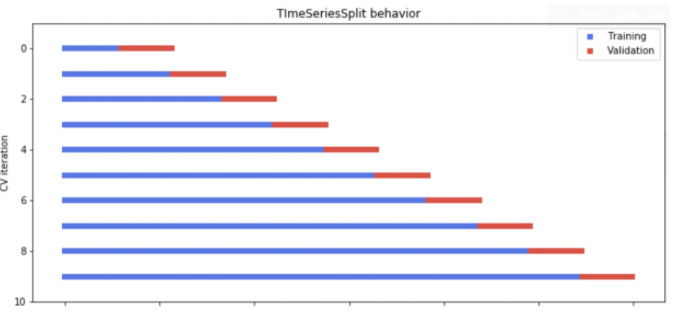


### 각 모델들의 성능을 비교하기 위한 함수들을 정의

In [87]:
# # 각 모델들의 성능을 비교하기 위한 함수들을 정의

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

def MAE(y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    return mae

def mae_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    mae_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_x), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_x.iloc[train_index], train_x.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mae = MAE(y_test, pred) 
        mae_list.append(mae)
    return model_name, mae_list

def print_mae_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = mae_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAE: {r:.4f}')
    print(f'\n{model_name} mean MAE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


### 간단하게 모델을 정의

모델 목록

1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Elasticnet Regression
5. Decision Tree
6. RandomForest Regressor
7. XGBoost Regressor
8. LightGBM Regressor
9. Catboost Regressor

In [88]:
reg = LinearRegression(n_jobs=-1)

ridge = Ridge(alpha=0.8, random_state=1)

lasso = Lasso(alpha = 0.01, random_state=1)

Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)

rf = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)

model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)

model_lgb = LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)


In [89]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_mae_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|███| 10/10 [00:00<00:00, 372.56it/s]


1 FOLDS: LinearRegression MAE: 96006612215.0962
2 FOLDS: LinearRegression MAE: 1511407710.1291
3 FOLDS: LinearRegression MAE: 925036174.3297
4 FOLDS: LinearRegression MAE: 909317738.1257
5 FOLDS: LinearRegression MAE: 368257943.7964
6 FOLDS: LinearRegression MAE: 411490551.5669
7 FOLDS: LinearRegression MAE: 388303152.3505
8 FOLDS: LinearRegression MAE: 290779211.6957
9 FOLDS: LinearRegression MAE: 227872877.6499
10 FOLDS: LinearRegression MAE: 351846676.0661

LinearRegression mean MAE: 10139092425.0806


Ridge Cross Validations...: 100%|██████████████| 10/10 [00:00<00:00, 641.56it/s]


1 FOLDS: Ridge MAE: 5265526812.9604
2 FOLDS: Ridge MAE: 1478329888.7667
3 FOLDS: Ridge MAE: 909171632.9378
4 FOLDS: Ridge MAE: 898199705.0218
5 FOLDS: Ridge MAE: 367305764.5855
6 FOLDS: Ridge MAE: 411061763.4424
7 FOLDS: Ridge MAE: 387962083.3347
8 FOLDS: Ridge MAE: 290634605.1170
9 FOLDS: Ridge MAE: 227722818.7145
10 FOLDS: Ridge MAE: 351423327.1375

Ridge mean MAE: 1058733840.2018


Lasso Cross Validations...: 100%|██████████████| 10/10 [00:00<00:00, 193.71it/s]


1 FOLDS: Lasso MAE: 14323726208.9798
2 FOLDS: Lasso MAE: 1511407710.1432
3 FOLDS: Lasso MAE: 925036174.0617
4 FOLDS: Lasso MAE: 909317737.9947
5 FOLDS: Lasso MAE: 368257943.7658
6 FOLDS: Lasso MAE: 411490551.5453
7 FOLDS: Lasso MAE: 388303152.3511
8 FOLDS: Lasso MAE: 290779211.6845
9 FOLDS: Lasso MAE: 227872877.6464
10 FOLDS: Lasso MAE: 351846676.1585

Lasso mean MAE: 1970803824.4331


ElasticNet Cross Validations...: 100%|█████████| 10/10 [00:00<00:00, 192.37it/s]


1 FOLDS: ElasticNet MAE: 4461597185.1225
2 FOLDS: ElasticNet MAE: 1281110253.3366
3 FOLDS: ElasticNet MAE: 785338983.0208
4 FOLDS: ElasticNet MAE: 773007883.3263
5 FOLDS: ElasticNet MAE: 355390446.5611
6 FOLDS: ElasticNet MAE: 402482528.9558
7 FOLDS: ElasticNet MAE: 378485392.9502
8 FOLDS: ElasticNet MAE: 287545371.1896
9 FOLDS: ElasticNet MAE: 223298407.3266
10 FOLDS: ElasticNet MAE: 334550917.8802

ElasticNet mean MAE: 928280736.9670


RandomForestRegressor Cross Validations...: 100%|█| 10/10 [00:03<00:00,  3.28it/


1 FOLDS: RandomForestRegressor MAE: 1351466401.4578
2 FOLDS: RandomForestRegressor MAE: 433605447.9445
3 FOLDS: RandomForestRegressor MAE: 397304377.3202
4 FOLDS: RandomForestRegressor MAE: 449877869.8346
5 FOLDS: RandomForestRegressor MAE: 301429448.5552
6 FOLDS: RandomForestRegressor MAE: 263404730.0525
7 FOLDS: RandomForestRegressor MAE: 98725892.8119
8 FOLDS: RandomForestRegressor MAE: 100004960.5718
9 FOLDS: RandomForestRegressor MAE: 64286275.0687
10 FOLDS: RandomForestRegressor MAE: 438277342.8671

RandomForestRegressor mean MAE: 389838274.6484


XGBRegressor Cross Validations...: 100%|████████| 10/10 [00:03<00:00,  3.00it/s]


1 FOLDS: XGBRegressor MAE: 1408956666.9245
2 FOLDS: XGBRegressor MAE: 304530336.8302
3 FOLDS: XGBRegressor MAE: 324621843.6038
4 FOLDS: XGBRegressor MAE: 376080564.2075
5 FOLDS: XGBRegressor MAE: 255267800.1686
6 FOLDS: XGBRegressor MAE: 181678673.6415
7 FOLDS: XGBRegressor MAE: 49753241.1946
8 FOLDS: XGBRegressor MAE: 74817975.7948
9 FOLDS: XGBRegressor MAE: 35921977.4176
10 FOLDS: XGBRegressor MAE: 252351295.9637

XGBRegressor mean MAE: 326398037.5747


LGBMRegressor Cross Validations...: 100%|███████| 10/10 [00:01<00:00,  8.53it/s]

1 FOLDS: LGBMRegressor MAE: 1645772167.7170
2 FOLDS: LGBMRegressor MAE: 415073986.8476
3 FOLDS: LGBMRegressor MAE: 414628042.1962
4 FOLDS: LGBMRegressor MAE: 403673062.8375
5 FOLDS: LGBMRegressor MAE: 286982530.4414
6 FOLDS: LGBMRegressor MAE: 203648268.3963
7 FOLDS: LGBMRegressor MAE: 57772912.5282
8 FOLDS: LGBMRegressor MAE: 71741090.7905
9 FOLDS: LGBMRegressor MAE: 47428494.4757
10 FOLDS: LGBMRegressor MAE: 317577935.8186

LGBMRegressor mean MAE: 386429849.2049


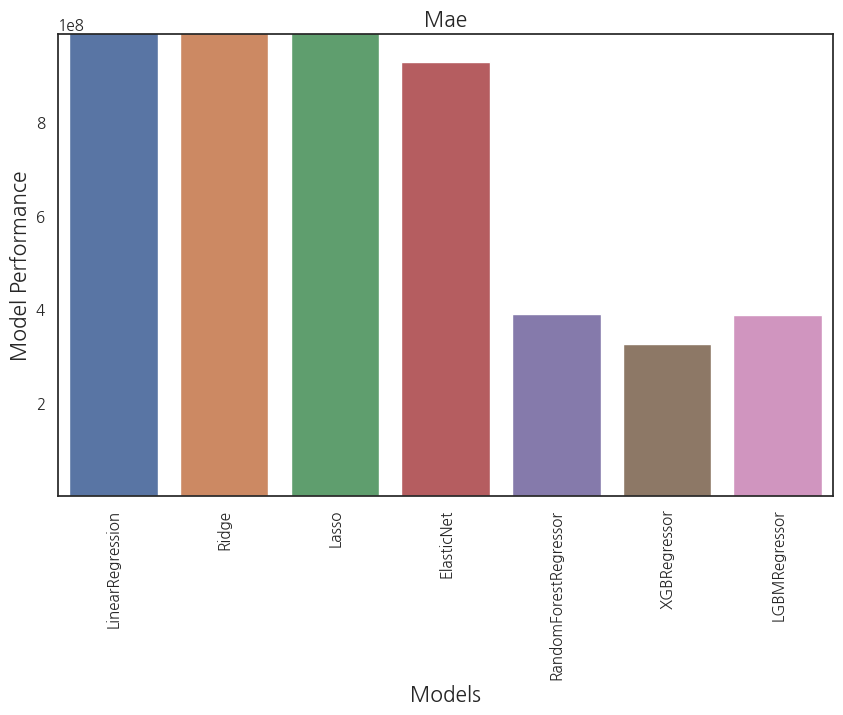

In [90]:
# 그래프로 비교하기

result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90)
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 987649968.2260)
plt.title('Mae', fontsize=15)
plt.show()

## 모델 정의 및 Optuna를 사용하여 하이퍼파라미터 탐색

### RandomForestRegressor

In [91]:
def objective(trial):
    # 하이퍼파라미터 탐색 대상
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)

    # RandomForestRegressor 모델 학습
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(train_x, train_y)

    # 검증 데이터로 평가
    y_pred = model.predict(val_x)
    mse = mean_squared_error(val_y, y_pred)
    return mse

# Optuna를 사용하여 하이퍼파라미터 탐색

study = optuna.create_study(direction='minimize')  # 목표는 최소화
study.optimize(objective, n_trials=100)  # 50회 반복하여 탐색

# 최적의 하이퍼파라미터 값 출력
best_params_rf = study.best_params
print("Best Params:", best_params_rf)

[I 2023-08-27 23:51:30,578] A new study created in memory with name: no-name-5b35c379-f98d-4372-aed9-62c33bca127c
[I 2023-08-27 23:51:30,643] Trial 0 finished with value: 1.044217275031154e+16 and parameters: {'n_estimators': 30, 'max_depth': 23}. Best is trial 0 with value: 1.044217275031154e+16.
[I 2023-08-27 23:51:30,808] Trial 1 finished with value: 1.23850852760433e+16 and parameters: {'n_estimators': 79, 'max_depth': 24}. Best is trial 0 with value: 1.044217275031154e+16.
[I 2023-08-27 23:51:30,947] Trial 2 finished with value: 1.3301711216456516e+16 and parameters: {'n_estimators': 67, 'max_depth': 19}. Best is trial 0 with value: 1.044217275031154e+16.
[I 2023-08-27 23:51:31,086] Trial 3 finished with value: 1.5846334423681028e+16 and parameters: {'n_estimators': 93, 'max_depth': 8}. Best is trial 0 with value: 1.044217275031154e+16.
[I 2023-08-27 23:51:31,178] Trial 4 finished with value: 1.980056188756604e+16 and parameters: {'n_estimators': 50, 'max_depth': 11}. Best is tria

Best Params: {'n_estimators': 32, 'max_depth': 27}


### XGBRegressor

In [92]:


def objective(trial):
    # 하이퍼파라미터 탐색 대상
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)

    # XGBRegressor 모델 학습
    model = xgb.XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             learning_rate=learning_rate,
                             random_state=7)
    model.fit(train_x, train_y)

    # 검증 데이터로 평가
    y_pred = model.predict(val_x)
    mse = mean_squared_error(val_y, y_pred)
    return mse

# Optuna를 사용하여 하이퍼파라미터 탐색
study = optuna.create_study(direction='minimize')  # 목표는 최소화
study.optimize(objective, n_trials=100)  # 50회 반복하여 탐색

# 최적의 하이퍼파라미터 값 출력
best_params_xgb = study.best_params
print("Best Params:", best_params_xgb)

[I 2023-08-27 23:51:38,486] A new study created in memory with name: no-name-4c276adc-b0e2-4fa4-845b-404cdaaa0dea
[I 2023-08-27 23:51:38,655] Trial 0 finished with value: 1.5709104718547856e+17 and parameters: {'n_estimators': 76, 'max_depth': 13, 'learning_rate': 0.023954709182977846}. Best is trial 0 with value: 1.5709104718547856e+17.
[I 2023-08-27 23:51:38,775] Trial 1 finished with value: 2.0622879159041552e+17 and parameters: {'n_estimators': 59, 'max_depth': 29, 'learning_rate': 0.02780425399701769}. Best is trial 0 with value: 1.5709104718547856e+17.
[I 2023-08-27 23:51:38,827] Trial 2 finished with value: 4.1465286558484264e+16 and parameters: {'n_estimators': 42, 'max_depth': 8, 'learning_rate': 0.06195132748714034}. Best is trial 2 with value: 4.1465286558484264e+16.
[I 2023-08-27 23:51:38,874] Trial 3 finished with value: 1.8252113318568835e+18 and parameters: {'n_estimators': 34, 'max_depth': 17, 'learning_rate': 0.01128249801464653}. Best is trial 2 with value: 4.14652865

Best Params: {'n_estimators': 86, 'max_depth': 25, 'learning_rate': 0.07196146727929859}


### LGBMRegressor

In [93]:
from lightgbm import LGBMRegressor
import numpy as np

def objective(trial):
    # 하이퍼파라미터 탐색 대상
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
    

    # LightGBMRegressor 모델 학습
    model = LGBMRegressor(n_estimators=n_estimators,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          random_state=7)
    model.fit(train_x, train_y)

    # 모델 예측
    val_pred = model.predict(val_x)

    # 평가 지표로 평균 제곱 오차 (Mean Squared Error, MSE)를 사용
    mse = np.mean((val_pred - val_y) ** 2)

    return mse

# Optuna를 사용하여 하이퍼파라미터 탐색
study = optuna.create_study(direction='minimize')  # 목표는 최소화
study.optimize(objective, n_trials=100)  # 50회 반복하여 탐색

# 최적의 하이퍼파라미터 값 출력
best_params_LGBM = study.best_params
print("Best Params:", best_params_LGBM)


[I 2023-08-27 23:52:25,884] A new study created in memory with name: no-name-b3baf8f5-2e55-49e4-b0c1-6b6e6013d554
[I 2023-08-27 23:52:26,012] Trial 0 finished with value: 2.3230911933671816e+16 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.0995096440700504}. Best is trial 0 with value: 2.3230911933671816e+16.
[I 2023-08-27 23:52:26,037] Trial 1 finished with value: 7.410020729418944e+17 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.011794728740099446}. Best is trial 0 with value: 2.3230911933671816e+16.
[I 2023-08-27 23:52:26,047] Trial 2 finished with value: 2.653865656243389e+16 and parameters: {'n_estimators': 43, 'max_depth': 4, 'learning_rate': 0.08175644846865723}. Best is trial 0 with value: 2.3230911933671816e+16.
[I 2023-08-27 23:52:26,078] Trial 3 finished with value: 3.0588540642769124e+16 and parameters: {'n_estimators': 68, 'max_depth': 23, 'learning_rate': 0.03846746287078055}. Best is trial 0 with value: 2.323091193367

Best Params: {'n_estimators': 70, 'max_depth': 29, 'learning_rate': 0.07283367289453604}


## 성능향상 확인을 위해 데이터의 기본 Feature만 이용하여 mae 확인 

In [94]:
from sklearn.ensemble import RandomForestRegressor



train_x = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'train', ['월별']]
train_y = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'train', '결제금액']
test_x = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'test', ['월별']]

# 모델 생성 및 훈련
model_rf = RandomForestRegressor(n_estimators=best_params_rf['n_estimators'],
                                max_depth=best_params_rf['max_depth'],
                                random_state=7)
model_rf.fit(train_x, train_y)

model_xgb = xgb.XGBRegressor(n_estimators=best_params_xgb['n_estimators'],
                          max_depth=best_params_xgb['max_depth'],
                          learning_rate=best_params_xgb['learning_rate'],
                          random_state=7)
model_xgb.fit(train_x, train_y)


model_LGBM = LGBMRegressor(n_estimators=best_params_LGBM['n_estimators'],
                          max_depth=best_params_LGBM['max_depth'],
                          learning_rate=best_params_LGBM['learning_rate'],
                          random_state=7)

model_LGBM.fit(train_x, train_y)



# 예측
pred_ls = list()
pred_ls_cb = list()
pred_ls_xgb = list()
pred_ls_LGBM = list()
pred_ls_rf=list()




now_df = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'train']
test = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'test']



for idx, row in tqdm(test.iterrows(), total = test.shape[0]):
    now_df = pd.concat([now_df, test.loc[[idx]]])


    
    # 예측

    pred_rf_ls = model_rf.predict(test_x.loc[idx:idx])
    pred_xgb_ls = model_xgb.predict(test_x.loc[idx:idx])
    pred_LGBM_ls = model_LGBM.predict(test_x.loc[idx:idx])
    
    blended_prediction = (pred_rf_ls + pred_xgb_ls + pred_LGBM_ls)/3
    
    now_df.loc[idx, '결제금액'] = blended_prediction
    pred_ls.append(blended_prediction[0])
    pred_ls_xgb.append(pred_xgb_ls[0])
    pred_ls_LGBM.append(pred_LGBM_ls[0])
    pred_ls_rf.append(pred_rf_ls[0])
    

pred_ls = pred_ls
pred_ls_xgb = pred_ls_xgb
pred_ls_LGBM = pred_ls_LGBM
pred_ls_rf = pred_ls_rf

확인용 = 지역화폐결제데이터합산_test

확인용.loc[:,'pred_ls'] = pred_ls
확인용.loc[:,'pred_ls_xgb'] = pred_ls_xgb
확인용.loc[:,'pred_ls_LGBM'] = pred_ls_LGBM
확인용.loc[:,'pred_ls_rf'] = pred_ls_rf

mae1 = mean_absolute_error(확인용['결제금액'], 확인용['pred_ls'])
mae3 = mean_absolute_error(확인용['결제금액'], 확인용['pred_ls_xgb'])
mae4 = mean_absolute_error(확인용['결제금액'], 확인용['pred_ls_LGBM'])
mae5 = mean_absolute_error(확인용['결제금액'], 확인용['pred_ls_rf'])

display('pred_ls',mae1,'pred_ls_xgb',mae3,'pred_ls_LGBM',mae4,'pred_ls_rf',mae5)

100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 22.78it/s]


'pred_ls'

1219853543.7094028

'pred_ls_xgb'

1221527990.7857144

'pred_ls_LGBM'

1221682628.6595535

'pred_ls_rf'

1216350011.682941

## test mae

In [95]:
from sklearn.ensemble import RandomForestRegressor



train_x = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'train', columns]
train_y = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'train', '결제금액']
test_x = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'test', columns]

# 모델 생성 및 훈련
model_rf = RandomForestRegressor(n_estimators=best_params_rf['n_estimators'],
                                max_depth=best_params_rf['max_depth'],
                                random_state=7)
model_rf.fit(train_x, train_y)

model_xgb = xgb.XGBRegressor(n_estimators=best_params_xgb['n_estimators'],
                          max_depth=best_params_xgb['max_depth'],
                          learning_rate=best_params_xgb['learning_rate'],
                          random_state=7)
model_xgb.fit(train_x, train_y)


model_LGBM = LGBMRegressor(n_estimators=best_params_LGBM['n_estimators'],
                          max_depth=best_params_LGBM['max_depth'],
                          learning_rate=best_params_LGBM['learning_rate'],
                          random_state=7)

model_LGBM.fit(train_x, train_y)



# 예측
pred_ls = list()
pred_ls_cb = list()
pred_ls_xgb = list()
pred_ls_LGBM = list()
pred_ls_rf=list()




now_df = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'train']
test = 지역화폐결제데이터합산ver2.loc[지역화폐결제데이터합산ver2['train_test'] == 'test']



for idx, row in tqdm(test.iterrows(), total = test.shape[0]):
    now_df = pd.concat([now_df, test.loc[[idx]]])


    
    # 예측

    pred_rf_ls = model_rf.predict(test_x.loc[idx:idx])
    pred_xgb_ls = model_xgb.predict(test_x.loc[idx:idx])
    pred_LGBM_ls = model_LGBM.predict(test_x.loc[idx:idx])
    
    blended_prediction = (pred_rf_ls + pred_xgb_ls + pred_LGBM_ls)/3
    
    now_df.loc[idx, '결제금액'] = blended_prediction
    pred_ls.append(blended_prediction[0])
    pred_ls_xgb.append(pred_xgb_ls[0])
    pred_ls_LGBM.append(pred_LGBM_ls[0])
    pred_ls_rf.append(pred_rf_ls[0])



100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 22.02it/s]


In [96]:

pred_ls = pred_ls
pred_ls_xgb = pred_ls_xgb
pred_ls_LGBM = pred_ls_LGBM
pred_ls_rf = pred_ls_rf

In [97]:
지역화폐결제데이터합산_test.loc[:,'pred_ls'] = pred_ls
지역화폐결제데이터합산_test.loc[:,'pred_ls_xgb'] = pred_ls_xgb
지역화폐결제데이터합산_test.loc[:,'pred_ls_LGBM'] = pred_ls_LGBM
지역화폐결제데이터합산_test.loc[:,'pred_ls_rf'] = pred_ls_rf

In [98]:
지역화폐결제데이터합산_test

,결제금액,pred_ls,pred_ls_xgb,pred_ls_LGBM,pred_ls_rf
43,6675276204,6105940110.23,6126382592.00,5913355897.37,6278081841.31
87,3174537938,3223863774.19,3203645952.00,3166742003.69,3301203366.88
131,2592699545,2556138705.40,2451501568.00,2670483882.53,2546430665.66
175,3483051897,3416590579.29,3426048256.00,3400020940.94,3423702540.94
219,2676548858,2623713214.10,2652983808.00,2498746982.97,2719408851.34
263,2951053704,2863259295.14,2903368448.00,2805143767.76,2881265669.66
307,2615745623,2623345113.39,2791987200.00,2461456913.75,2616591226.44
351,1738499695,1618358437.72,1583298944.00,1636405570.66,1635370798.50
395,2656246108,2619912223.91,2663952128.00,2482449526.94,2713335016.78
439,1506302227,1798271886.17,2145069056.00,1389749896.07,1859996706.44


In [99]:
mae1 = mean_absolute_error(지역화폐결제데이터합산_test['결제금액'], 지역화폐결제데이터합산_test['pred_ls'])
#mae2 = mean_absolute_error(지역화폐결제데이터합산_test['결제금액'], 지역화폐결제데이터합산_test['pred_ls_cb'])
mae3 = mean_absolute_error(지역화폐결제데이터합산_test['결제금액'], 지역화폐결제데이터합산_test['pred_ls_xgb'])
mae4 = mean_absolute_error(지역화폐결제데이터합산_test['결제금액'], 지역화폐결제데이터합산_test['pred_ls_LGBM'])
mae5 = mean_absolute_error(지역화폐결제데이터합산_test['결제금액'], 지역화폐결제데이터합산_test['pred_ls_rf'])

display('pred_ls',mae1,'pred_ls_xgb',mae3,'pred_ls_LGBM',mae4,'pred_ls_rf',mae5)

'pred_ls'

68448399.68966824

'pred_ls_xgb'

88934183.23214285

'pred_ls_LGBM'

88300729.48253854

'pred_ls_rf'

64138323.38839286

## 변수 중요도

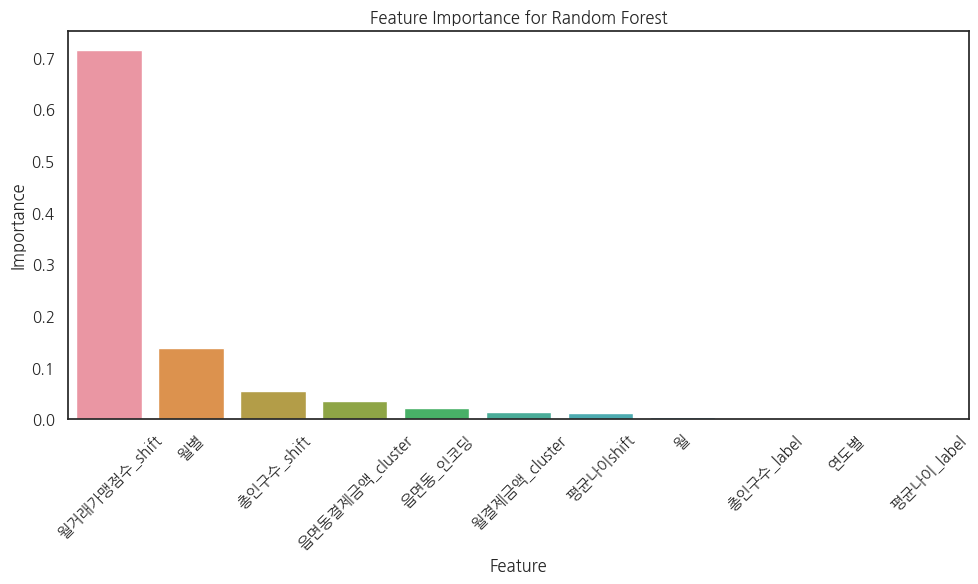

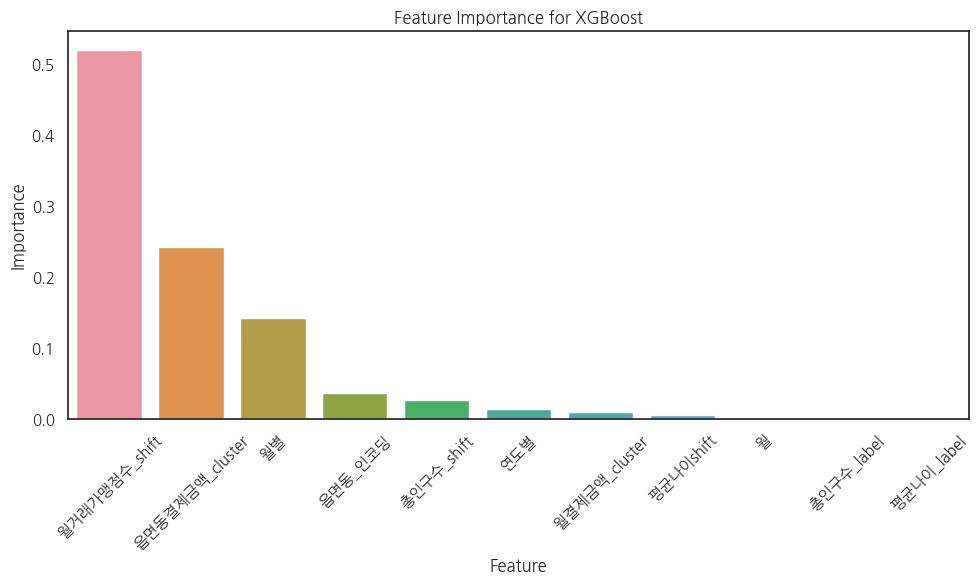

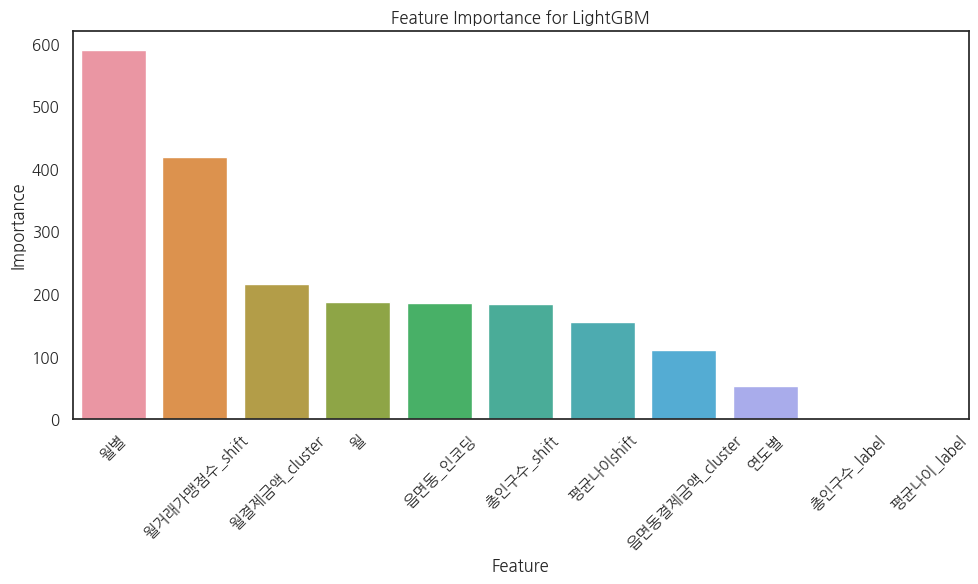

In [100]:
model_names = ["Random Forest", "XGBoost", "LightGBM"]
models = [model_rf, model_xgb, model_LGBM]

for model, model_name in zip(models, model_names):
    feature_importance = model.feature_importances_
    feature_names = columns
    feature_importance_with_names = list(zip(feature_names, feature_importance))
    feature_importance_with_names_sorted = sorted(feature_importance_with_names, key=lambda x: x[1], reverse=True)
    
    # Feature Importance를 seaborn의 barplot으로 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[name for name, _ in feature_importance_with_names_sorted], y=[importance for _, importance in feature_importance_with_names_sorted])
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title(f"Feature Importance for {model_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



# 마케팅용 시각화 코드

Text(0.5, 1.0, '고연령 지역 점포수')

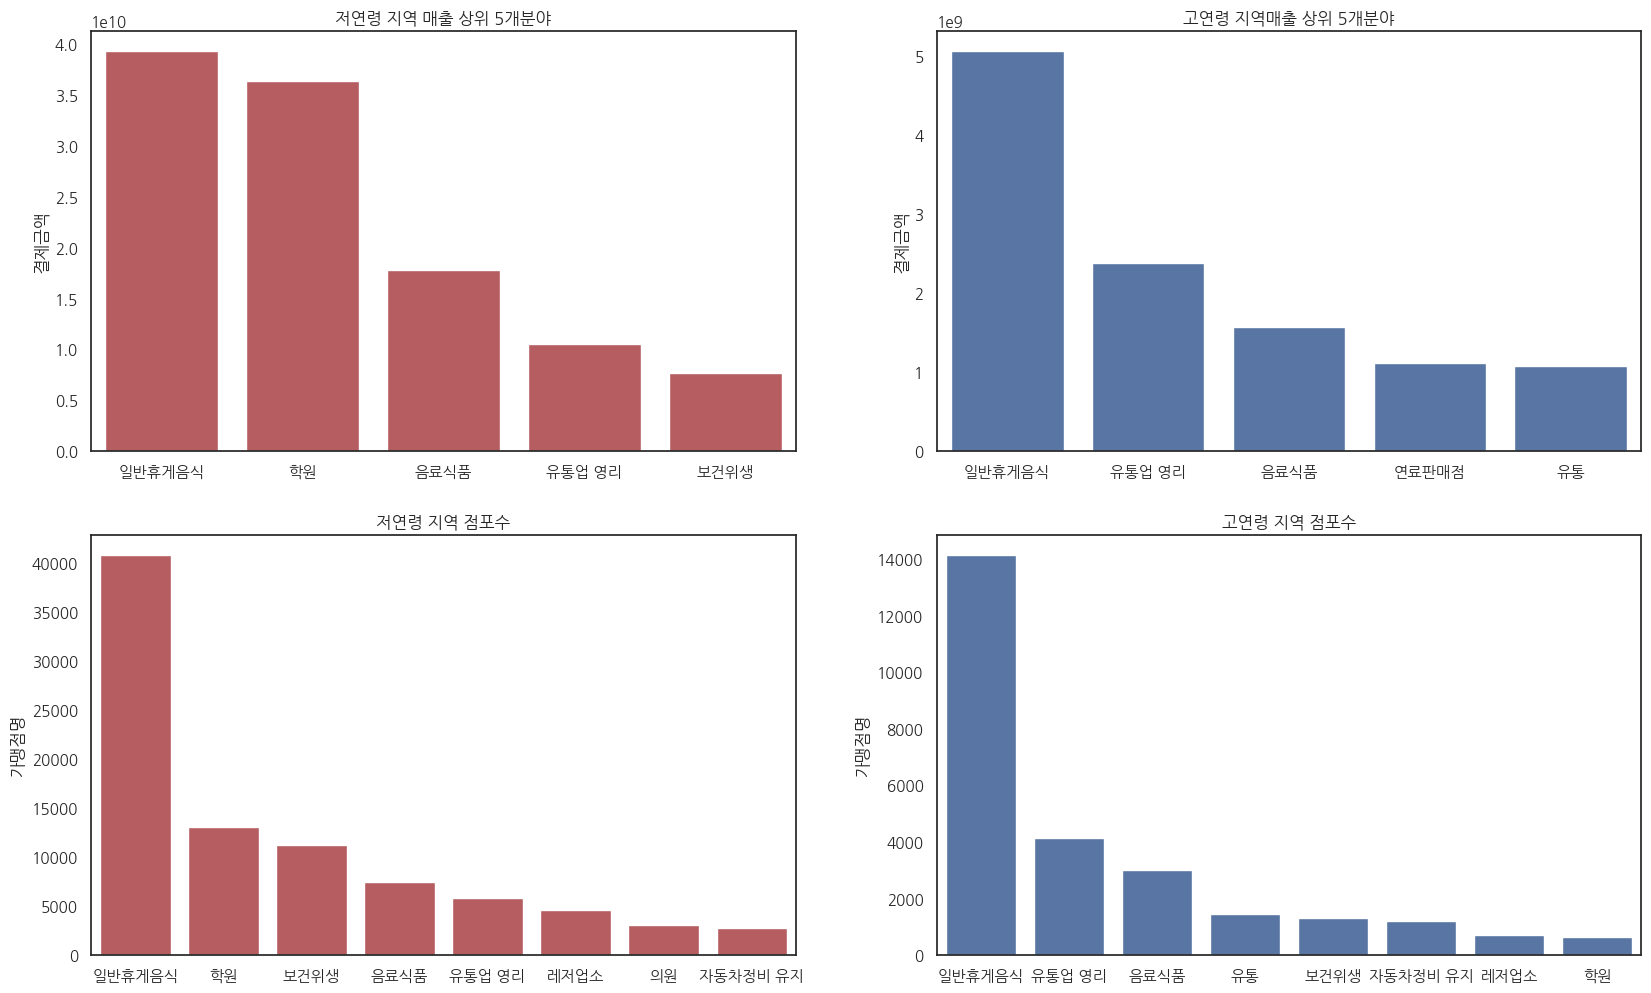

In [101]:
########################################마케팅용

#2022년 10월 평균연령을 가져와 상위/하위 지역 분리

인구22년10월=화성시_copy.iloc[[-1]].T.drop(['연월','연도'], axis=0).sort_values(69)
인구22년10월.mean()


# 전체지역 평균 연령 44.86세






import seaborn as sns
import matplotlib.pyplot as plt
a
#2022년(~10월) 평균연령 상위/하위 구역 구별

지역화폐결제데이터합산_2022_train=지역화폐결제데이터합산[ (지역화폐결제데이터합산['연도별']>=2022) & (지역화폐결제데이터합산['train_test']=='train' )]


상위=list(인구22년10월.head(11).index) ### 44.86세 이하
하위=list(인구22년10월.tail(10).index) ### 44.86세 이상





youngcity=지역화폐결제데이터합산_2022_train[지역화폐결제데이터합산_2022_train['읍면동'].isin(상위)]
oldcity=지역화폐결제데이터합산_2022_train[지역화폐결제데이터합산_2022_train['읍면동'].isin(하위)]





#대분류명을 기준으로 결제금액의 총합 그룹화

ya=youngcity.groupby(['대분류명'])['결제금액'].sum()
yd=pd.DataFrame(ya).sort_values('결제금액', ascending=False).head()


ob=oldcity.groupby(['대분류명'])['결제금액'].sum()
od=pd.DataFrame(ob).sort_values('결제금액', ascending=False).head()

#대분류명을 기준으로 가맹점 수 그룹화

yb=youngcity.groupby(['대분류명'])['가맹점명'].count()
yc=pd.DataFrame(yb).sort_values('가맹점명', ascending=False).head(8)

oa=oldcity.groupby(['대분류명'])['가맹점명'].count()
oc=pd.DataFrame(oa).sort_values('가맹점명', ascending=False).head(8)



#각 구역 별 매출 지분 상위 5개 분야 시각화
#각 구역 별 점포 수 상위 5개 분야 시각화



plt.rc("font", family = "NanumGothic")
sns.set(font="NanumGothic", 
rc={"axes.unicode_minus":False}, style='white')


fig, axs = plt.subplots(ncols= 2,nrows=2, figsize=(20,12))

ax0=sns.barplot(x=list(yd.index), y=yd['결제금액'], ax=axs[0,0], color='r')
ax0.set_title("저연령 지역 매출 상위 5개분야")

ax1=sns.barplot(x=list(od.index), y=od['결제금액'], ax=axs[0,1], color='b')
ax1.set_title("고연령 지역매출 상위 5개분야")

ax2=sns.barplot(x=list(yc.index), y=yc['가맹점명'], ax=axs[1,0], color='r')
ax2.set_title("저연령 지역 점포수")

ax3=sns.barplot(x=list(oc.index), y=oc['가맹점명'], ax=axs[1,1], color='b')
ax3.set_title("고연령 지역 점포수")
